## Preparación de Data


Note: you may need to restart the kernel to use updated packages.
Datos de IBB guardados. Período: 2001-02-12 00:00:00 a 2025-03-17 00:00:00
             open    high     low   close  adjusted_close   volume  \
2001-02-12  100.5  104.00  100.50  103.50       33.195736  32400.0   
2001-02-13  105.0  106.20  100.10  100.50       32.233541  17200.0   
2001-02-14  100.7  100.70   96.35   98.70       31.656224   8200.0   
2001-02-15  100.0  100.00   98.80   99.75       31.992992   7800.0   
2001-02-16   97.4   98.45   96.30   96.75       31.030797   8100.0   

            dividend_amount  split_coefficient  
2001-02-12              0.0                1.0  
2001-02-13              0.0                1.0  
2001-02-14              0.0                1.0  
2001-02-15              0.0                1.0  
2001-02-16              0.0                1.0  


Descargando datos:  67%|██████▋   | 10/15 [00:22<00:10,  2.04s/it]

Error al obtener datos para BGNE: Invalid API call. Please retry or visit the documentation (https://www.alphavantage.co/documentation/) for TIME_SERIES_DAILY_ADJUSTED.


Descargando datos: 100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


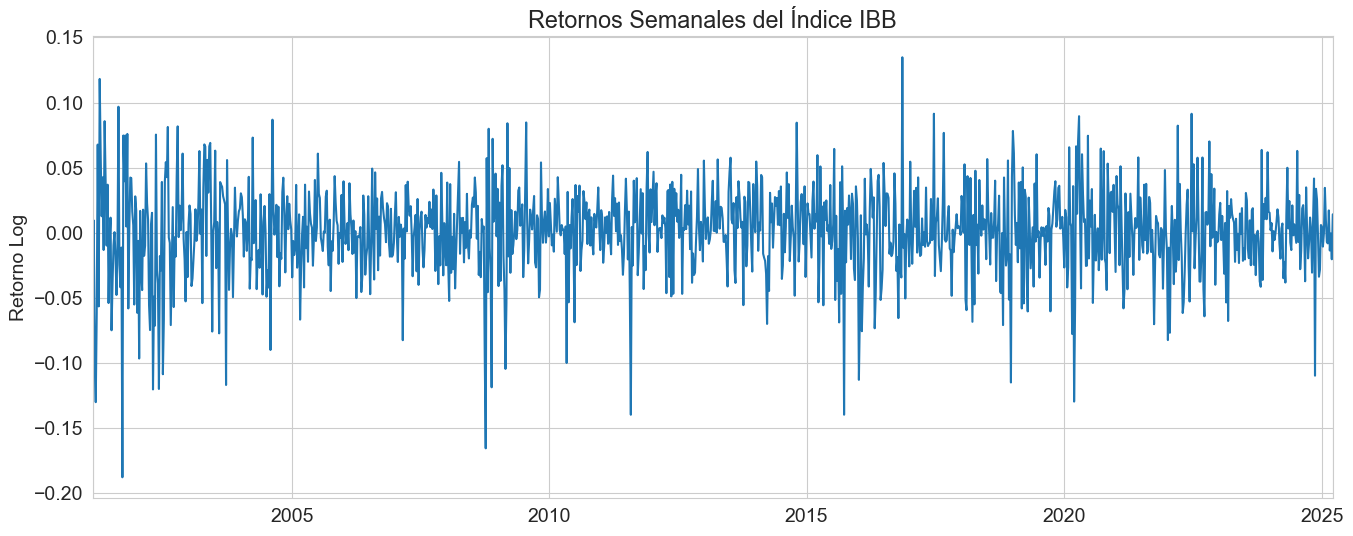

Período de datos: 2018-12-14 00:00:00 a 2021-07-30 00:00:00
Número de observaciones: 138
Número de activos: 15
                AMGN      GILD      BIIB      REGN      ILMN      VRTX  \
2018-12-14  0.003285 -0.030165 -0.006907  0.022123  0.015590 -0.012563   
2018-12-21 -0.063737 -0.046034 -0.114213 -0.100861 -0.157598 -0.083095   
2018-12-28  0.056736 -0.011888  0.045016  0.050971  0.067155  0.030954   
2019-01-04  0.024395  0.097980  0.081143  0.091965  0.014844  0.067546   
2019-01-11  0.025860 -0.001320  0.045684  0.027489  0.014367  0.085737   

                BMRN      ALXN      INCY      SGEN      MRNA      NBIX  \
2018-12-14  0.004413 -0.054851  0.026615  0.008135 -0.015168 -0.165500   
2018-12-21 -0.140321 -0.145311 -0.121507 -0.143215 -0.235916 -0.018676   
2018-12-28  0.032583  0.026899  0.059712  0.063393 -0.022363 -0.022970   
2019-01-04  0.041013  0.086566  0.148769  0.064158  0.181143  0.087803   
2019-01-11  0.081120  0.047262  0.032401  0.181790  0.002356  0.150338   


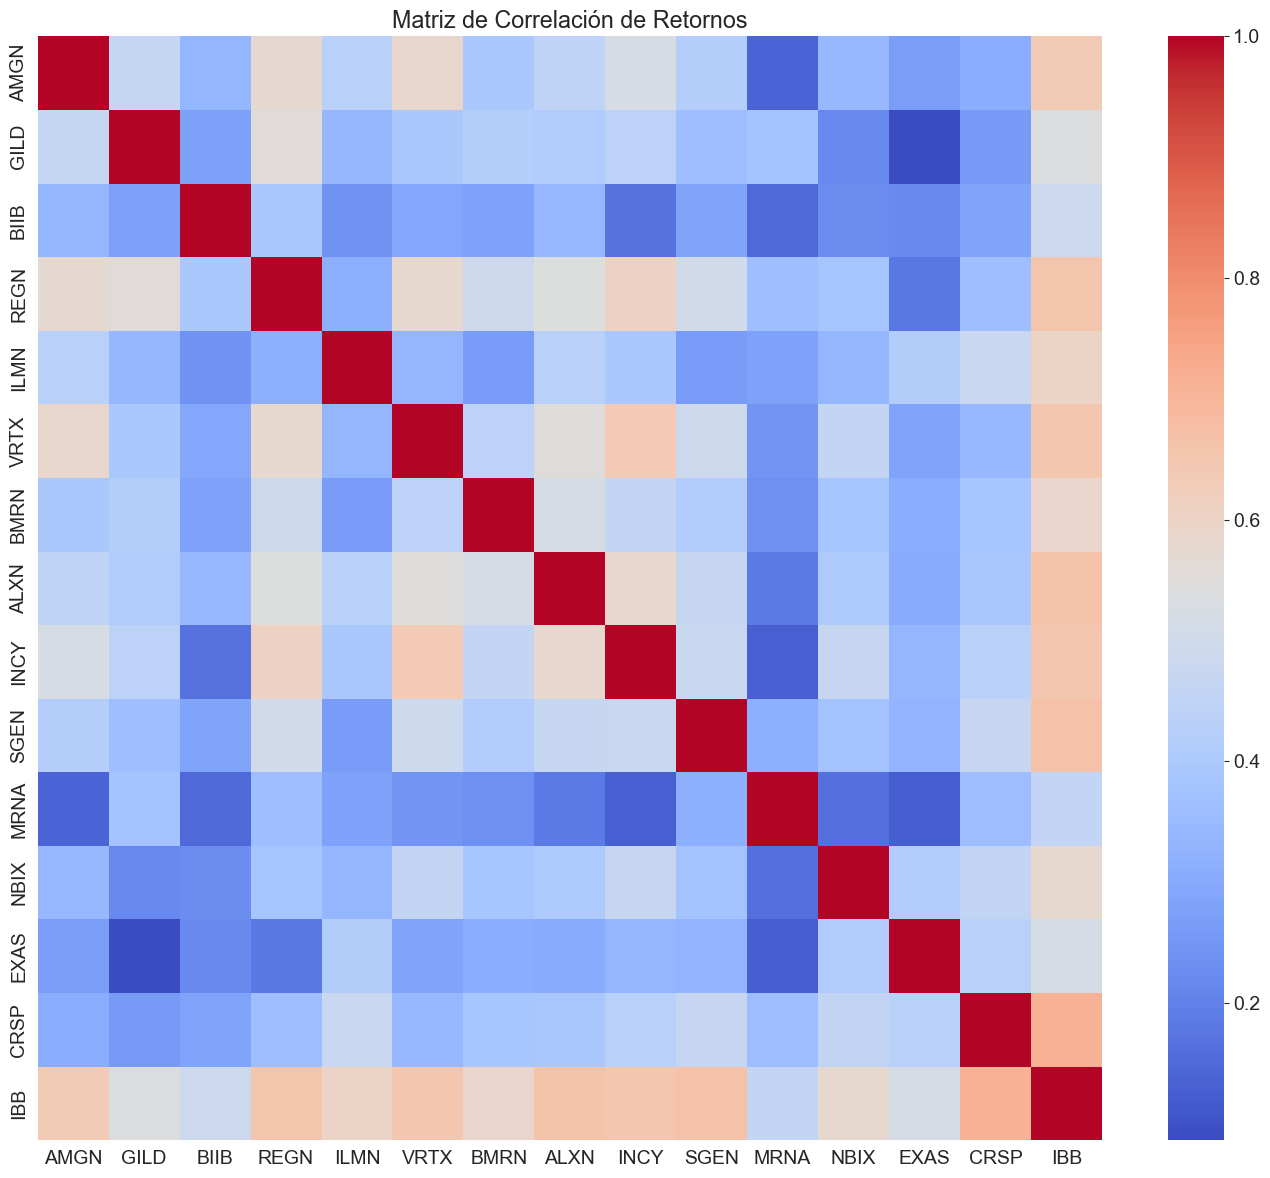

Fecha de corte para división: 2020-10-16 00:00:00
Conjunto de entrenamiento: 97 observaciones
Conjunto de validación: 42 observaciones
X_train: (97, 14), y_train: (97,)
X_valid: (42, 14), y_valid: (42,)
X_train_scaled: (97, 14)
X_valid_scaled: (42, 14)
      count      mean       std       min       25%       50%       75%  \
MRNA  138.0  0.021341  0.119932 -0.329405 -0.053111  0.012439  0.075960   
SGEN  138.0  0.006803  0.061086 -0.169500 -0.026842  0.003745  0.040837   
IBB   138.0  0.003443  0.036286 -0.129630 -0.019914  0.004781  0.027481   
CRSP  138.0  0.008977  0.095794 -0.363384 -0.047971  0.005313  0.068310   
REGN  138.0  0.003135  0.045849 -0.138715 -0.021184  0.002623  0.031764   
ALXN  138.0  0.003309  0.053505 -0.145311 -0.022695  0.003532  0.028581   
AMGN  138.0  0.002204  0.037422 -0.109263 -0.021323  0.003264  0.025567   
ILMN  138.0  0.003140  0.055123 -0.215027 -0.023835  0.006313  0.034939   
EXAS  138.0  0.002958  0.075467 -0.232250 -0.036516  0.013740  0.048712 

<Figure size 1600x800 with 0 Axes>

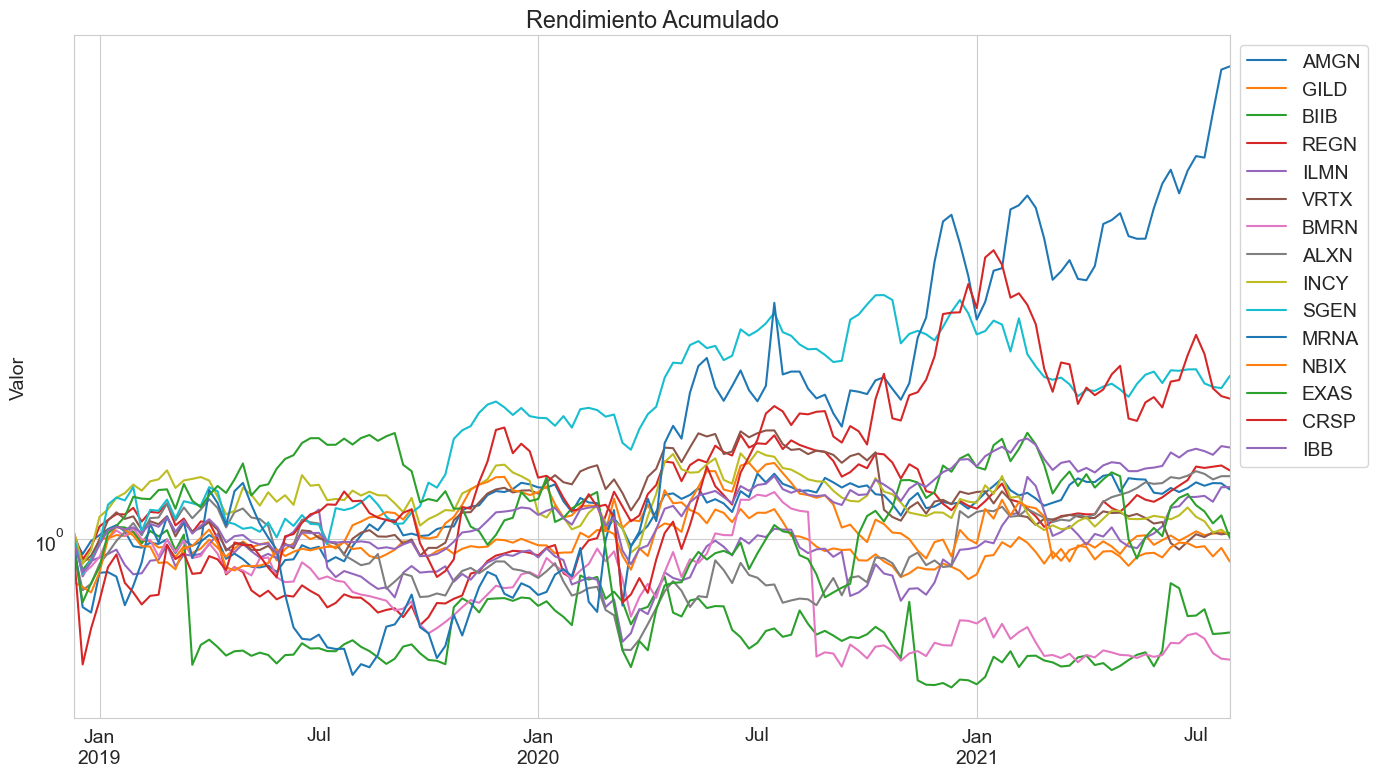

Datos secuenciales - X_train_seq: (93, 4, 14), y_train_seq: (93,)
Datos secuenciales - X_valid_seq: (38, 4, 14), y_valid_seq: (38,)
Datos preparados correctamente para Deep Portfolio Theory.


In [2]:

import os
import json
import pickle
import time
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%pip install riskfolio-lib
import riskfolio as rp

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 14

os.makedirs('../data', exist_ok=True)

DEFAULT_API_KEY = "OPKM64U0O4TDT4OJ"  

def get_stock_data(symbol, api_key=DEFAULT_API_KEY, output_size="full"):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize={output_size}&apikey={api_key}"
    
    try:
        r = requests.get(url)
        data = r.json()
        
        if 'Error Message' in data:
            print(f"Error al obtener datos para {symbol}: {data['Error Message']}")
            return None
        
        if 'Time Series (Daily)' not in data:
            print(f"No hay datos disponibles para {symbol}")
            return None
        
        df = pd.DataFrame(data['Time Series (Daily)']).T
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        
        for col in df.columns:
            df[col] = df[col].astype(float)
        
        df.columns = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount', 'split_coefficient']
        
        return df
    
    except Exception as e:
        print(f"Error al obtener datos para {symbol}: {str(e)}")
        return None

def download_multiple_stocks(symbols, api_key=DEFAULT_API_KEY, output_size="full", sleep_time=12):
    stock_data = {}
    
    for symbol in tqdm(symbols, desc="Descargando datos"):
        df = get_stock_data(symbol, api_key, output_size)
        
        if df is not None:
            stock_data[symbol] = df
            df.to_csv(f"../data/{symbol}_daily.csv")
        
        time.sleep(1)
    
    return stock_data

def calculate_returns(df, price_col='adjusted_close', freq='W-FRI', log_returns=True):
    price_resampled = df[price_col].resample(freq).last()
    
    if log_returns:
        returns = np.log(price_resampled / price_resampled.shift(1))
    else:
        returns = price_resampled / price_resampled.shift(1) - 1
    
    return returns.dropna()

def prepare_dataset(data_dict, benchmark_symbol, freq='W-FRI', log_returns=True):
    returns_dict = {}
    
    if benchmark_symbol in data_dict:
        benchmark_returns = calculate_returns(data_dict[benchmark_symbol], freq=freq, log_returns=log_returns)
        returns_dict[benchmark_symbol] = benchmark_returns
    else:
        print(f"Advertencia: No se encontró el benchmark {benchmark_symbol} en los datos")
    
    for symbol, df in data_dict.items():
        if symbol != benchmark_symbol:
            returns = calculate_returns(df, freq=freq, log_returns=log_returns)
            returns_dict[symbol] = returns
    
    all_returns = pd.DataFrame(returns_dict)
    all_returns = all_returns.dropna()
    
    return all_returns

def split_train_valid(returns_df, train_ratio=0.7, benchmark_col=None):
    cutoff_idx = int(len(returns_df) * train_ratio)
    cutoff_date = returns_df.index[cutoff_idx]
    
    train_data = returns_df.loc[:cutoff_date].copy()
    valid_data = returns_df.loc[cutoff_date:].copy()
    
    if benchmark_col is not None:
        X_train = train_data.drop(columns=[benchmark_col])
        y_train = train_data[benchmark_col]
        
        X_valid = valid_data.drop(columns=[benchmark_col])
        y_valid = valid_data[benchmark_col]
        
        return X_train, y_train, X_valid, y_valid
    
    return train_data, valid_data

def preprocess_data(X_train, X_valid, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
    else:
        X_train_scaled = scaler.transform(X_train)
    
    X_valid_scaled = scaler.transform(X_valid)
    
    return X_train_scaled, X_valid_scaled, scaler

def create_sequence_data(X, y, lookback):
    X_seq, y_seq = [], []
    
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
    
    return np.array(X_seq), np.array(y_seq)

def get_benchmark_components(benchmark, n_components=30, api_key=DEFAULT_API_KEY):
    benchmark_components = {
        'IBB': [
            "AMGN", "GILD", "BIIB", "REGN", "ILMN", "VRTX", "BMRN", "ALXN",
            "INCY", "SGEN", "BGNE", "MRNA", "NBIX", "EXAS", "CRSP", "ALNY",
            "NVAX", "IONS", "JAZZ", "UTHR", "SRPT", "GBT", "ARNA", "ACAD"
        ],
        'SPY': [
            "AAPL", "MSFT", "AMZN", "FB", "GOOGL", "GOOG", "BRK.B", "JNJ",
            "PG", "V", "JPM", "UNH", "MA", "INTC", "VZ", "HD", "NVDA", "DIS",
            "BAC", "ADBE", "NFLX", "T", "XOM", "CSCO", "MRK"
        ]
    }
    
    if benchmark in benchmark_components:
        return benchmark_components[benchmark][:n_components]
    else:
        print(f"Componentes para el índice {benchmark} no disponibles. Retornando lista vacía.")
        return []

# EJECUCIÓN PRINCIPAL
benchmark_symbol = "IBB"
ibb_data = get_stock_data(benchmark_symbol)

if ibb_data is not None:
    ibb_data.to_csv(f"../data/{benchmark_symbol}_daily.csv")
    print(f"Datos de {benchmark_symbol} guardados. Período: {ibb_data.index.min()} a {ibb_data.index.max()}")
    print(ibb_data.head())

# Componentes principales del IBB
ibb_components = [
    "AMGN", "GILD", "BIIB", "REGN", "ILMN", "VRTX", "BMRN", "ALXN",
    "INCY", "SGEN", "BGNE", "MRNA", "NBIX", "EXAS", "CRSP"
]

components_data = download_multiple_stocks(ibb_components)

# Método 1: Procesar datos manualmente
ibb_weekly_returns = calculate_returns(ibb_data)

plt.figure(figsize=(16, 6))
ibb_weekly_returns.plot()
plt.title('Retornos Semanales del Índice IBB')
plt.ylabel('Retorno Log')
plt.show()

weekly_returns = {}
for symbol, df in components_data.items():
    weekly_returns[symbol] = calculate_returns(df)

all_returns = pd.DataFrame(weekly_returns)
all_returns['IBB'] = ibb_weekly_returns
all_returns = all_returns.dropna()

print(f"Período de datos: {all_returns.index.min()} a {all_returns.index.max()}")
print(f"Número de observaciones: {len(all_returns)}")
print(f"Número de activos: {all_returns.shape[1]}")
print(all_returns.head())

# Método 2: Usar función integrada
all_data = components_data.copy()
all_data[benchmark_symbol] = ibb_data
all_returns_method2 = prepare_dataset(all_data, benchmark_symbol)

print("Comparación de métodos (deberían ser similares):")
print(f"Método 1: {all_returns.shape}")
print(f"Método 2: {all_returns_method2.shape}")

all_returns.to_csv("../data/all_weekly_returns.csv")

# Visualizar matriz de correlación
plt.figure(figsize=(14, 12))
sns.heatmap(all_returns.corr(), annot=False, cmap='coolwarm')
plt.title('Matriz de Correlación de Retornos')
plt.tight_layout()
plt.show()

# División train/valid - Método 1
cutoff_date = all_returns.index[int(len(all_returns) * 0.7)]
print(f"Fecha de corte para división: {cutoff_date}")

train_data = all_returns.loc[:cutoff_date].copy()
valid_data = all_returns.loc[cutoff_date:].copy()

print(f"Conjunto de entrenamiento: {len(train_data)} observaciones")
print(f"Conjunto de validación: {len(valid_data)} observaciones")

train_data.to_csv("../data/train_weekly_returns.csv")
valid_data.to_csv("../data/valid_weekly_returns.csv")

# Método 2: Usando función integrada
X_train, y_train, X_valid, y_valid = split_train_valid(all_returns, benchmark_col=benchmark_symbol)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")

# Normalizar datos
X_train_scaled, X_valid_scaled, scaler = preprocess_data(X_train, X_valid)

print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_valid_scaled: {X_valid_scaled.shape}")

# Estadísticas descriptivas
stats = all_returns.describe().T
stats['sharpe'] = stats['mean'] / stats['std'] * np.sqrt(52)  # Ratio Sharpe anualizado
stats['skew'] = all_returns.skew()
stats['kurt'] = all_returns.kurt()

stats_sorted = stats.sort_values('sharpe', ascending=False)
print(stats_sorted)

# Visualizar rendimiento acumulado
cumulative_returns = (1 + all_returns).cumprod()

plt.figure(figsize=(16, 8))
cumulative_returns.plot()
plt.title('Rendimiento Acumulado')
plt.ylabel('Valor')
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Datos secuenciales para modelos RNN
lookback = 4  # 4 semanas de historia
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train.values, lookback)
X_valid_seq, y_valid_seq = create_sequence_data(X_valid_scaled, y_valid.values, lookback)

print(f"Datos secuenciales - X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}")
print(f"Datos secuenciales - X_valid_seq: {X_valid_seq.shape}, y_valid_seq: {y_valid_seq.shape}")

print("Datos preparados correctamente para Deep Portfolio Theory.")

## Implementación de Deep Portfolio Theory

1. Cargando y preprocesando datos...
Datos de entrenamiento: (97, 14)
Datos de validación: (42, 14)

2. Implementando paso 1: Auto-codificación (Encode)...

Entrenando autoencoder con dim=3, reg=0.001
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0427 - val_loss: 0.9137
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0361 - val_loss: 0.9100
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0312 - val_loss: 0.9070
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0270 - val_loss: 0.9043
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0232 - val_loss: 0.9019
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0197 - val_loss: 0.8997
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0169 - val_loss: 0.8979
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0144 - val_loss: 0.8962
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0119 - val_loss: 0.8945
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

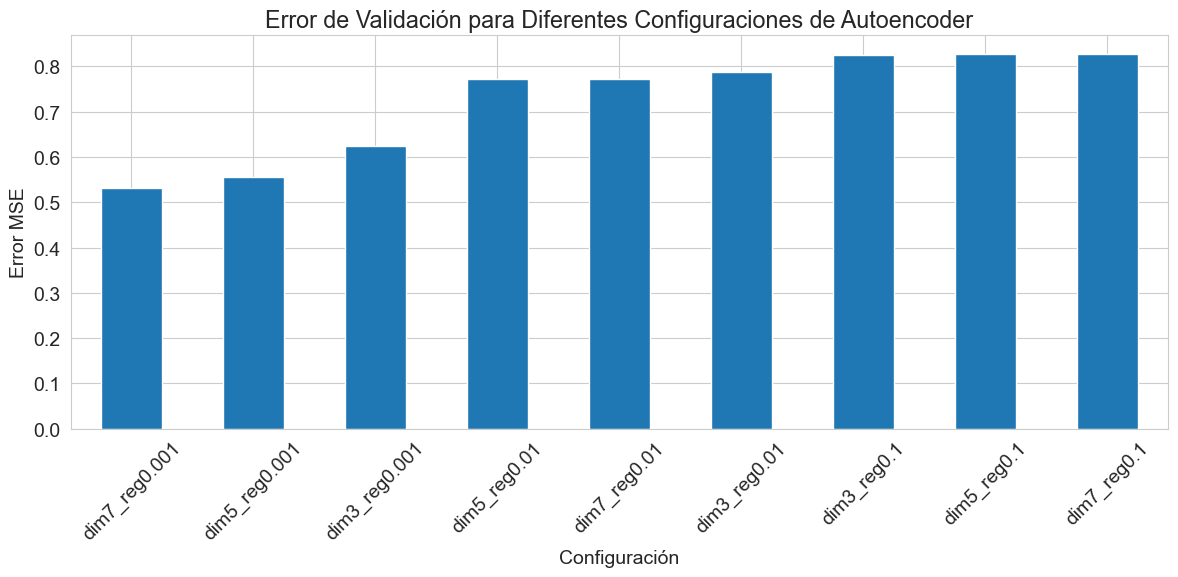

Mejor configuración: dim7_reg0.001 con error de validación: 0.532255


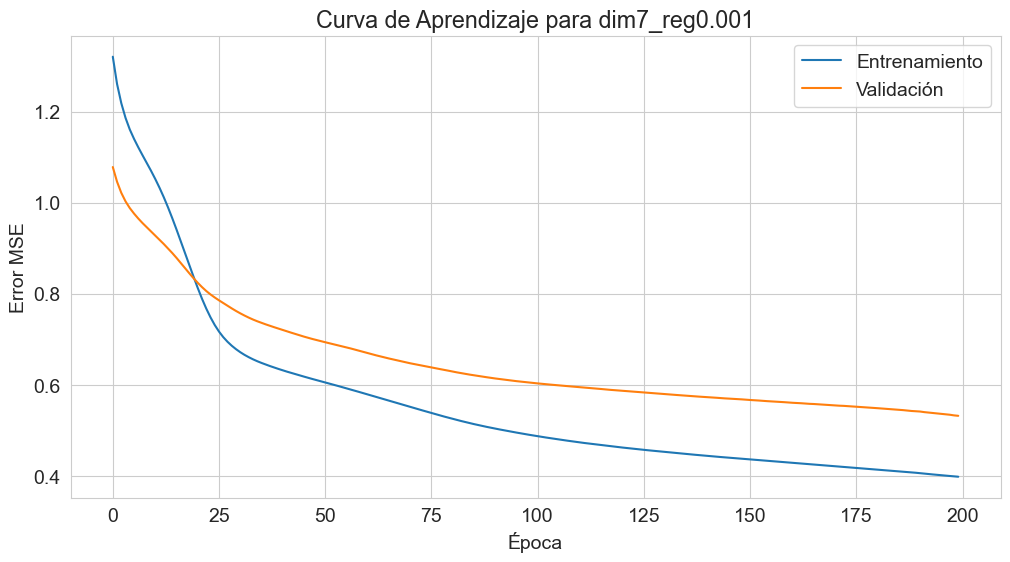

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Características codificadas (entrenamiento):
                   0         1         2         3         4         5  \
2018-12-14  0.802769  1.018687  2.984090  0.000000  1.054218  1.285425   
2018-12-21  4.885077  4.421828  5.039448  1.519647  0.579474  5.791199   
2018-12-28  1.267039  0.506513  0.938732  1.213689  2.722599  0.133658   
2019-01-04  1.904516  0.766709  1.881694  2.733052  4.739446  1.807687   
2019-01-11  2.608642  0.249227  0.109003  2.622765  3.584921  1.843989   

                   6  
2018-12-14  1.964099  
2018-12-21  5.615284  
2018-12-28  0.847339  
2019-01-04  0.187906  
2019-01-11  0.885397  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


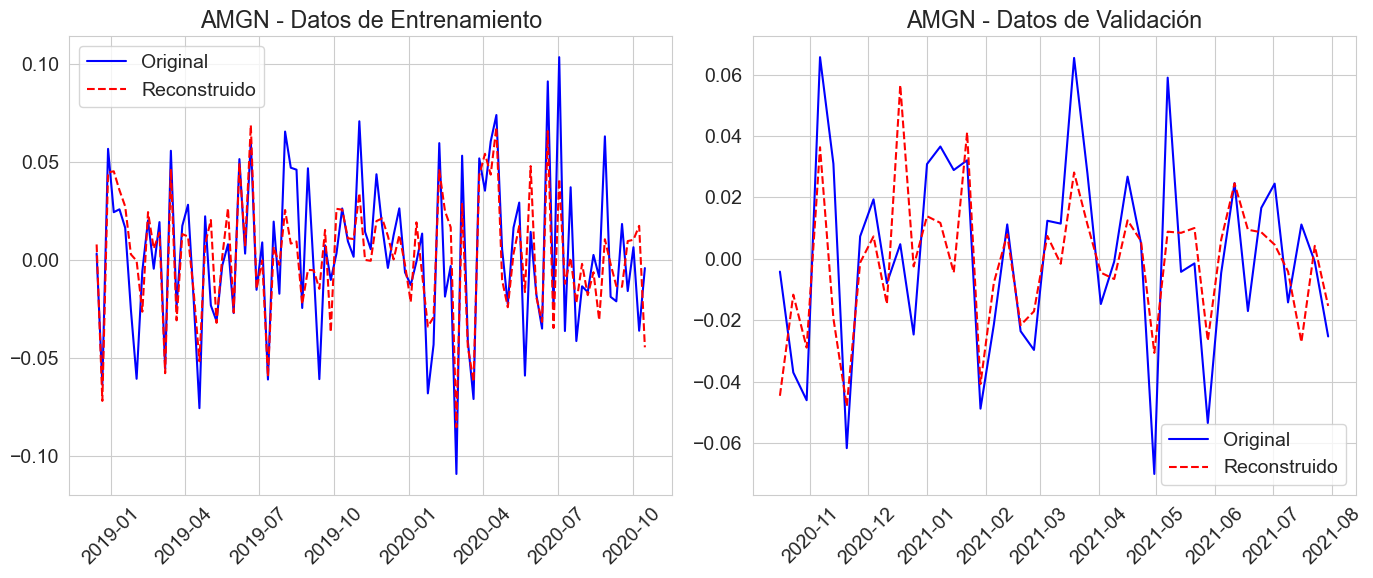

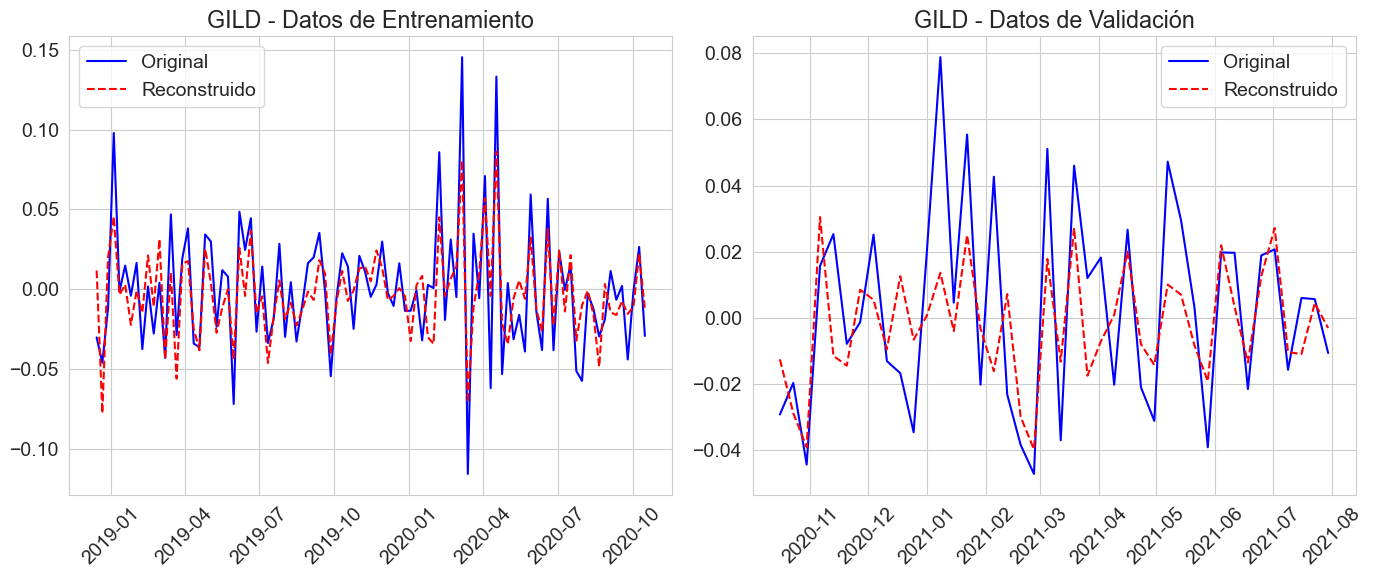

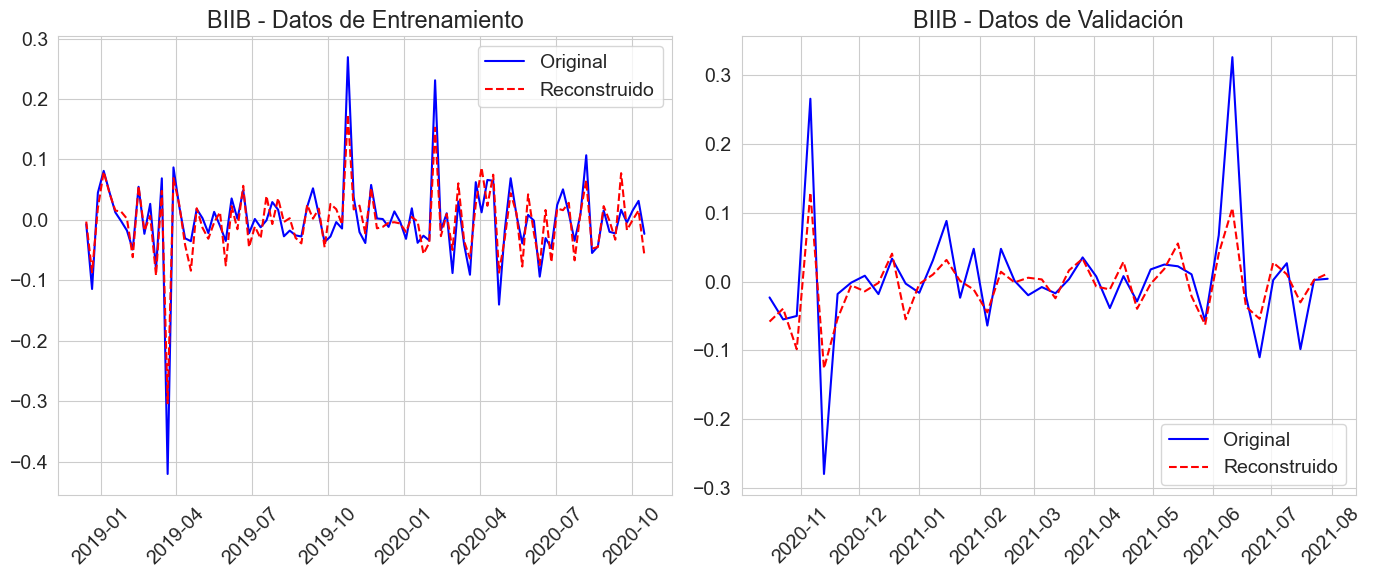


3. Implementando paso 2: Calibración (Calibrate)...

Entrenando modelo de portfolio con dim=3, reg=0.001
Epoch 1/200


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2217 - val_loss: 0.3740
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1699 - val_loss: 0.2987
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1347 - val_loss: 0.2430
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1099 - val_loss: 0.2029
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0926 - val_loss: 0.1736
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0812 - val_loss: 0.1523
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0736 - val_loss: 0.1370
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0686 - val_loss: 0.1257
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0653 - val_loss: 0.1176
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0633 - val_loss: 0.1119
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0619 - val_loss: 0.1075
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0608 - val_loss: 0.1040
Epoch 13/200

In [ ]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 14

np.random.seed(42)
tf.random.set_seed(42)

os.makedirs('../models', exist_ok=True)


class DeepPortfolioAutoencoder:
    def __init__(self, input_dim, encoding_dim=5, hidden_layers=None, reg_strength=0.01, 
                 activation='relu', learning_rate=0.001):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.hidden_layers = hidden_layers if hidden_layers is not None else [encoding_dim * 2]
        self.reg_strength = reg_strength
        self.activation = activation
        self.learning_rate = learning_rate
        
        self.autoencoder, self.encoder, self.decoder = self._build_models()
    
    def _build_models(self):
        regularizer = l1_l2(l1=self.reg_strength, l2=self.reg_strength)
        
        input_layer = Input(shape=(self.input_dim,))
        
        x = input_layer
        encoder_layers = []
        
        for i, units in enumerate(self.hidden_layers):
            x = Dense(units, activation=self.activation, kernel_regularizer=regularizer,
                      name=f'encoder_{i}')(x)
            encoder_layers.append(x)
        
        encoded = Dense(self.encoding_dim, activation=self.activation, kernel_regularizer=regularizer,
                        name='encoded')(x)
        
        x = encoded
        for i, units in enumerate(reversed(self.hidden_layers)):
            x = Dense(units, activation=self.activation, kernel_regularizer=regularizer,
                      name=f'decoder_{i}')(x)
        
        decoded = Dense(self.input_dim, activation='linear', kernel_regularizer=regularizer,
                       name='decoded')(x)
        
        autoencoder = Model(input_layer, decoded, name='autoencoder')
        encoder = Model(input_layer, encoded, name='encoder')
        
        encoded_input = Input(shape=(self.encoding_dim,))
        decoder_layers = []
        x = encoded_input
        
        for i, layer in enumerate(autoencoder.layers[len(self.hidden_layers) + 2:]):
            x = layer(x)
            decoder_layers.append(x)
        
        decoder = Model(encoded_input, x, name='decoder')
        
        autoencoder.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        
        return autoencoder, encoder, decoder
    
    def fit(self, X_train, X_valid=None, epochs=100, batch_size=32, patience=20, 
            model_path=None, verbose=1):
        callbacks = []
        
        if X_valid is not None:
            early_stopping = EarlyStopping(monitor='val_loss', patience=patience, 
                                          restore_best_weights=True)
            callbacks.append(early_stopping)
        
        if model_path is not None:
            os.makedirs(os.path.dirname(model_path), exist_ok=True)
            
            checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)
            callbacks.append(checkpoint)
        
        validation_data = (X_valid, X_valid) if X_valid is not None else None
        
        history = self.autoencoder.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=verbose
        )
        
        return history
    
    def encode(self, X):
        return self.encoder.predict(X)
    
    def decode(self, encoded_X):
        return self.decoder.predict(encoded_X)
    
    def reconstruct(self, X):
        return self.autoencoder.predict(X)
    
    def evaluate(self, X):
        return self.autoencoder.evaluate(X, X, verbose=0)
    
    def save(self, model_dir):
        os.makedirs(model_dir, exist_ok=True)
        
        self.autoencoder.save(os.path.join(model_dir, 'autoencoder.h5'))
        self.encoder.save(os.path.join(model_dir, 'encoder.h5'))
        self.decoder.save(os.path.join(model_dir, 'decoder.h5'))
    
    @classmethod
    def load(cls, model_dir):
        autoencoder = load_model(os.path.join(model_dir, 'autoencoder.h5'))
        encoder = load_model(os.path.join(model_dir, 'encoder.h5'))
        decoder = load_model(os.path.join(model_dir, 'decoder.h5'))
        
        instance = cls.__new__(cls)
        
        instance.autoencoder = autoencoder
        instance.encoder = encoder
        instance.decoder = decoder
        instance.input_dim = autoencoder.input_shape[1]
        instance.encoding_dim = encoder.output_shape[1]
        
        return instance


class DeepPortfolioModel:
    def __init__(self, input_dim, hidden_layers=None, reg_strength=0.01, 
                 activation='relu', learning_rate=0.001):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers if hidden_layers is not None else [32, 16]
        self.reg_strength = reg_strength
        self.activation = activation
        self.learning_rate = learning_rate
        
        self.model = self._build_model()
    
    def _build_model(self):
        regularizer = l1_l2(l1=self.reg_strength, l2=self.reg_strength)
        
        model = Sequential()
        
        model.add(Dense(self.hidden_layers[0], activation=self.activation, 
                        kernel_regularizer=regularizer, input_shape=(self.input_dim,)))
        
        for units in self.hidden_layers[1:]:
            model.add(Dense(units, activation=self.activation, kernel_regularizer=regularizer))
        
        model.add(Dense(1, activation='linear', kernel_regularizer=regularizer))
        
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        
        return model
    
    def fit(self, X_train, y_train, X_valid=None, y_valid=None, epochs=100, batch_size=32, 
            patience=20, model_path=None, verbose=1):
        callbacks = []
        
        if X_valid is not None and y_valid is not None:
            early_stopping = EarlyStopping(monitor='val_loss', patience=patience, 
                                          restore_best_weights=True)
            callbacks.append(early_stopping)
        
        if model_path is not None:
            os.makedirs(os.path.dirname(model_path), exist_ok=True)
            
            checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)
            callbacks.append(checkpoint)
        
        validation_data = (X_valid, y_valid) if X_valid is not None and y_valid is not None else None
        
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=verbose
        )
        
        return history
    
    def predict(self, X):
        return self.model.predict(X).flatten()
    
    def evaluate(self, X, y):
        return self.model.evaluate(X, y, verbose=0)
    
    def save(self, model_path):
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        
        self.model.save(model_path)
    
    @classmethod
    def load(cls, model_path):
        model = load_model(model_path)
        
        instance = cls.__new__(cls)
        
        instance.model = model
        instance.input_dim = model.input_shape[1]
        
        return instance


def evaluate_portfolio_model(model, X_train, y_train, X_valid, y_valid, scaler=None):
    y_train_pred = model.predict(X_train).flatten()
    y_valid_pred = model.predict(X_valid).flatten()
    
    train_mse = np.mean((y_train - y_train_pred) ** 2)
    valid_mse = np.mean((y_valid - y_valid_pred) ** 2)
    
    train_cum_actual = (1 + y_train).cumprod()
    train_cum_pred = (1 + y_train_pred).cumprod()
    valid_cum_actual = (1 + y_valid).cumprod()
    valid_cum_pred = (1 + y_valid_pred).cumprod()
    
    train_total_return_actual = train_cum_actual[-1] - 1
    train_total_return_pred = train_cum_pred[-1] - 1
    valid_total_return_actual = valid_cum_actual[-1] - 1
    valid_total_return_pred = valid_cum_pred[-1] - 1
    
    train_vol_actual = np.std(y_train) * np.sqrt(52)  # Anualizado
    train_vol_pred = np.std(y_train_pred) * np.sqrt(52)
    valid_vol_actual = np.std(y_valid) * np.sqrt(52)
    valid_vol_pred = np.std(y_valid_pred) * np.sqrt(52)
    
    train_sharpe_actual = (np.mean(y_train) * 52) / train_vol_actual if train_vol_actual > 0 else 0
    train_sharpe_pred = (np.mean(y_train_pred) * 52) / train_vol_pred if train_vol_pred > 0 else 0
    valid_sharpe_actual = (np.mean(y_valid) * 52) / valid_vol_actual if valid_vol_actual > 0 else 0
    valid_sharpe_pred = (np.mean(y_valid_pred) * 52) / valid_vol_pred if valid_vol_pred > 0 else 0
    
    train_tracking_error = np.std(y_train - y_train_pred) * np.sqrt(52)
    valid_tracking_error = np.std(y_valid - y_valid_pred) * np.sqrt(52)
    
    return {
        'train_mse': train_mse,
        'valid_mse': valid_mse,
        'train_tracking_error': train_tracking_error,
        'valid_tracking_error': valid_tracking_error,
        'train_total_return_actual': train_total_return_actual,
        'train_total_return_pred': train_total_return_pred,
        'valid_total_return_actual': valid_total_return_actual,
        'valid_total_return_pred': valid_total_return_pred,
        'train_vol_actual': train_vol_actual,
        'train_vol_pred': train_vol_pred,
        'valid_vol_actual': valid_vol_actual,
        'valid_vol_pred': valid_vol_pred,
        'train_sharpe_actual': train_sharpe_actual,
        'train_sharpe_pred': train_sharpe_pred,
        'valid_sharpe_actual': valid_sharpe_actual,
        'valid_sharpe_pred': valid_sharpe_pred,
        'y_train_pred': y_train_pred,
        'y_valid_pred': y_valid_pred
    }


def plot_cumulative_returns(y_true, y_pred, title, train_dates, valid_dates):
    y_true_train = pd.Series(y_true[:len(train_dates)], index=train_dates)
    y_pred_train = pd.Series(y_pred[:len(train_dates)], index=train_dates)
    y_true_valid = pd.Series(y_true[len(train_dates):], index=valid_dates)
    y_pred_valid = pd.Series(y_pred[len(train_dates):], index=valid_dates)
    
    train_cum_actual = (1 + y_true_train).cumprod()
    train_cum_pred = (1 + y_pred_train).cumprod()
    valid_cum_actual = (1 + y_true_valid).cumprod()
    valid_cum_pred = (1 + y_pred_valid).cumprod()
    
    valid_cum_actual = valid_cum_actual / valid_cum_actual.iloc[0] * train_cum_actual.iloc[-1]
    valid_cum_pred = valid_cum_pred / valid_cum_pred.iloc[0] * train_cum_pred.iloc[-1]
    
    plt.figure(figsize=(14, 6))
    
    plt.plot(train_dates, train_cum_actual, 'b-', label='Real (Train)')
    plt.plot(train_dates, train_cum_pred, 'r--', label='Predicho (Train)')
    
    plt.plot(valid_dates, valid_cum_actual, 'g-', label='Real (Valid)')
    plt.plot(valid_dates, valid_cum_pred, 'm--', label='Predicho (Valid)')
    
    plt.axvline(x=train_dates[-1], color='black', linestyle='-', alpha=0.3)
    
    plt.title(title)
    plt.xlabel('Fecha')
    plt.ylabel('Valor Acumulado')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def build_model_with_n_assets(n_assets, X_train, y_train, X_valid, y_valid, asset_names, latent_dim=5, reg_strength=0.01):
    lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
    importances = np.abs(lasso.coef_)
    
    top_indices = np.argsort(importances)[::-1][:n_assets]
    top_assets = [asset_names[i] for i in top_indices]
    
    X_train_subset = X_train[:, top_indices]
    X_valid_subset = X_valid[:, top_indices]
    
    model = DeepPortfolioModel(
        input_dim=n_assets,
        hidden_layers=[latent_dim * 2, latent_dim, latent_dim * 2],
        reg_strength=reg_strength
    )
    
    model.fit(
        X_train=X_train_subset,
        y_train=y_train,
        X_valid=X_valid_subset,
        y_valid=y_valid,
        epochs=200,
        batch_size=16,
        patience=20,
        verbose=0
    )
    
    metrics = evaluate_portfolio_model(model, X_train_subset, y_train, X_valid_subset, y_valid)
    
    return model, metrics, top_indices, top_assets


def markowitz_optimization(returns, target_return=None, risk_aversion=1.0):
    n = returns.shape[1]
    returns_mean = returns.mean().values
    returns_cov = returns.cov().values
    
    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(returns_cov, weights)))
    
    def portfolio_return(weights):
        return np.sum(returns_mean * weights)
    
    def objective(weights):
        if target_return is None:
            return portfolio_volatility(weights) - risk_aversion * portfolio_return(weights)
        else:
            return portfolio_volatility(weights)
    
    constraints = []
    if target_return is not None:
        constraints.append({'type': 'eq', 'fun': lambda w: portfolio_return(w) - target_return})
    
    constraints.append({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0})
    
    bounds = tuple((0, 1) for _ in range(n))
    
    initial_weights = np.ones(n) / n
    
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result['x']


# 1. Carga y Preprocesamiento de Datos
print("1. Cargando y preprocesando datos...")

train_data = pd.read_csv("../data/train_weekly_returns.csv", index_col=0, parse_dates=True)
valid_data = pd.read_csv("../data/valid_weekly_returns.csv", index_col=0, parse_dates=True)

ibb_train = train_data['IBB']
assets_train = train_data.drop('IBB', axis=1)

ibb_valid = valid_data['IBB']
assets_valid = valid_data.drop('IBB', axis=1)

print(f"Datos de entrenamiento: {assets_train.shape}")
print(f"Datos de validación: {assets_valid.shape}")

scaler = StandardScaler()
assets_train_scaled = scaler.fit_transform(assets_train)
assets_valid_scaled = scaler.transform(assets_valid)

asset_names = assets_train.columns.tolist()


# 2. Implementación del Paso 1: Auto-codificación (Encode)
print("\n2. Implementando paso 1: Auto-codificación (Encode)...")

encoding_dims = [3, 5, 7]
reg_strengths = [0.001, 0.01, 0.1]
autoencoder_results = {}

for encoding_dim in encoding_dims:
    for reg_strength in reg_strengths:
        print(f"\nEntrenando autoencoder con dim={encoding_dim}, reg={reg_strength}")
        
        autoencoder = DeepPortfolioAutoencoder(
            input_dim=len(asset_names),
            encoding_dim=encoding_dim,
            hidden_layers=[encoding_dim * 2],
            reg_strength=reg_strength
        )
        
        history = autoencoder.fit(
            X_train=assets_train_scaled,
            X_valid=assets_valid_scaled,
            epochs=200,
            batch_size=16,
            patience=20,
            verbose=1
        )
        
        train_loss = autoencoder.evaluate(assets_train_scaled)
        valid_loss = autoencoder.evaluate(assets_valid_scaled)
        
        key = f"dim{encoding_dim}_reg{reg_strength}"
        autoencoder_results[key] = {
            'autoencoder': autoencoder,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'history': history.history
        }
        
        print(f"Error de entrenamiento: {train_loss:.6f}")
        print(f"Error de validación: {valid_loss:.6f}")

valid_errors = {k: v['valid_loss'] for k, v in autoencoder_results.items()}
valid_errors = pd.Series(valid_errors).sort_values()

plt.figure(figsize=(12, 6))
valid_errors.plot(kind='bar')
plt.title('Error de Validación para Diferentes Configuraciones de Autoencoder')
plt.ylabel('Error MSE')
plt.xlabel('Configuración')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

best_config = valid_errors.index[0]
print(f"Mejor configuración: {best_config} con error de validación: {valid_errors.iloc[0]:.6f}")

best_autoencoder = autoencoder_results[best_config]['autoencoder']

history = autoencoder_results[best_config]['history']

plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Entrenamiento')
plt.plot(history['val_loss'], label='Validación')
plt.title(f'Curva de Aprendizaje para {best_config}')
plt.xlabel('Época')
plt.ylabel('Error MSE')
plt.legend()
plt.grid(True)
plt.show()

encoded_train = best_autoencoder.encode(assets_train_scaled)
encoded_valid = best_autoencoder.encode(assets_valid_scaled)

print("Características codificadas (entrenamiento):")
print(pd.DataFrame(encoded_train, index=train_data.index).head())

reconstructed_train = best_autoencoder.reconstruct(assets_train_scaled)
reconstructed_valid = best_autoencoder.reconstruct(assets_valid_scaled)

reconstructed_train = scaler.inverse_transform(reconstructed_train)
reconstructed_valid = scaler.inverse_transform(reconstructed_valid)

reconstructed_train_df = pd.DataFrame(reconstructed_train, index=train_data.index, columns=asset_names)
reconstructed_valid_df = pd.DataFrame(reconstructed_valid, index=valid_data.index, columns=asset_names)

selected_assets = asset_names[:3]

for asset in selected_assets:
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_data.index, assets_train[asset], label='Original', color='blue')
    plt.plot(train_data.index, reconstructed_train_df[asset], label='Reconstruido', color='red', linestyle='--')
    plt.title(f'{asset} - Datos de Entrenamiento')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.plot(valid_data.index, assets_valid[asset], label='Original', color='blue')
    plt.plot(valid_data.index, reconstructed_valid_df[asset], label='Reconstruido', color='red', linestyle='--')
    plt.title(f'{asset} - Datos de Validación')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


# 3. Implementación del Paso 2: Calibración (Calibrate)
print("\n3. Implementando paso 2: Calibración (Calibrate)...")

latent_dims = [3, 5, 7]
reg_strengths = [0.001, 0.01, 0.1]
tracking_results = {}

for latent_dim in latent_dims:
    for reg_strength in reg_strengths:
        print(f"\nEntrenando modelo de portfolio con dim={latent_dim}, reg={reg_strength}")
        
        model = DeepPortfolioModel(
            input_dim=len(asset_names),
            hidden_layers=[latent_dim * 2, latent_dim, latent_dim * 2],
            reg_strength=reg_strength
        )
        
        history = model.fit(
            X_train=assets_train_scaled,
            y_train=ibb_train.values,
            X_valid=assets_valid_scaled,
            y_valid=ibb_valid.values,
            epochs=200,
            batch_size=16,
            patience=20,
            verbose=1
        )
        
        train_loss = model.evaluate(assets_train_scaled, ibb_train.values)
        valid_loss = model.evaluate(assets_valid_scaled, ibb_valid.values)
        
        key = f"dim{latent_dim}_reg{reg_strength}"
        tracking_results[key] = {
            'model': model,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'history': history.history
        }
        
        print(f"Error de entrenamiento: {train_loss:.6f}")
        print(f"Error de validación: {valid_loss:.6f}")

tracking_valid_errors = {k: v['valid_loss'] for k, v in tracking_results.items()}
tracking_valid_errors = pd.Series(tracking_valid_errors).sort_values()

plt.figure(figsize=(12, 6))
tracking_valid_errors.plot(kind='bar')
plt.title('Error de Validación para Diferentes Configuraciones del Modelo de Seguimiento')
plt.ylabel('Error MSE')
plt.xlabel('Configuración')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

best_tracking_config = tracking_valid_errors.index[0]
print(f"Mejor configuración: {best_tracking_config} con error de validación: {tracking_valid_errors.iloc[0]:.6f}")

best_tracking_model = tracking_results[best_tracking_config]['model']

weekly_outperformance = 0.01 / 52
ibb_train_outperform = ibb_train + weekly_outperformance
ibb_valid_outperform = ibb_valid + weekly_outperformance

outperform_results = {}

for latent_dim in latent_dims:
    for reg_strength in reg_strengths:
        print(f"\nEntrenando modelo de superación con dim={latent_dim}, reg={reg_strength}")
        
        model = DeepPortfolioModel(
            input_dim=len(asset_names),
            hidden_layers=[latent_dim * 2, latent_dim, latent_dim * 2],
            reg_strength=reg_strength
        )
        
        history = model.fit(
            X_train=assets_train_scaled,
            y_train=ibb_train_outperform.values,
            X_valid=assets_valid_scaled,
            y_valid=ibb_valid_outperform.values,
            epochs=200,
            batch_size=16,
            patience=20,
            verbose=1
        )
        
        train_loss = model.evaluate(assets_train_scaled, ibb_train_outperform.values)
        valid_loss = model.evaluate(assets_valid_scaled, ibb_valid_outperform.values)
        
        key = f"dim{latent_dim}_reg{reg_strength}"
        outperform_results[key] = {
            'model': model,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'history': history.history
        }
        
        print(f"Error de entrenamiento: {train_loss:.6f}")
        print(f"Error de validación: {valid_loss:.6f}")

outperform_valid_errors = {k: v['valid_loss'] for k, v in outperform_results.items()}
outperform_valid_errors = pd.Series(outperform_valid_errors).sort_values()

plt.figure(figsize=(12, 6))
outperform_valid_errors.plot(kind='bar')
plt.title('Error de Validación para Diferentes Configuraciones del Modelo de Superación')
plt.ylabel('Error MSE')
plt.xlabel('Configuración')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

best_outperform_config = outperform_valid_errors.index[0]
print(f"Mejor configuración: {best_outperform_config} con error de validación: {outperform_valid_errors.iloc[0]:.6f}")

best_outperform_model = outperform_results[best_outperform_config]['model']


# 4. Implementación del Paso 3: Validación (Validate)
print("\n4. Implementando paso 3: Validación (Validate)...")

tracking_metrics = evaluate_portfolio_model(
    best_tracking_model,
    assets_train_scaled,
    ibb_train.values,
    assets_valid_scaled,
    ibb_valid.values
)

outperform_metrics = evaluate_portfolio_model(
    best_outperform_model,
    assets_train_scaled,
    ibb_train_outperform.values,
    assets_valid_scaled,
    ibb_valid_outperform.values
)

print("\nMétricas del Modelo de Seguimiento:")
print(f"MSE Validación: {tracking_metrics['valid_mse']:.6f}")
print(f"Tracking Error Validación: {tracking_metrics['valid_tracking_error']:.4f}")
print(f"Sharpe Ratio Real (Valid): {tracking_metrics['valid_sharpe_actual']:.4f}")
print(f"Sharpe Ratio Pred (Valid): {tracking_metrics['valid_sharpe_pred']:.4f}")
print(f"Retorno Total Real (Valid): {tracking_metrics['valid_total_return_actual']:.4f}")
print(f"Retorno Total Pred (Valid): {tracking_metrics['valid_total_return_pred']:.4f}")

print("\nMétricas del Modelo de Superación:")
print(f"MSE Validación: {outperform_metrics['valid_mse']:.6f}")
print(f"Tracking Error Validación: {outperform_metrics['valid_tracking_error']:.4f}")
print(f"Sharpe Ratio Real (Valid): {outperform_metrics['valid_sharpe_actual']:.4f}")
print(f"Sharpe Ratio Pred (Valid): {outperform_metrics['valid_sharpe_pred']:.4f}")
print(f"Retorno Total Real (Valid): {outperform_metrics['valid_total_return_actual']:.4f}")
print(f"Retorno Total Pred (Valid): {outperform_metrics['valid_total_return_pred']:.4f}")

y_true_tracking = np.concatenate([ibb_train.values, ibb_valid.values])
y_pred_tracking = np.concatenate([tracking_metrics['y_train_pred'], tracking_metrics['y_valid_pred']])

y_true_outperform = np.concatenate([ibb_train_outperform.values, ibb_valid_outperform.values])
y_pred_outperform = np.concatenate([outperform_metrics['y_train_pred'], outperform_metrics['y_valid_pred']])

train_dates = train_data.index
valid_dates = valid_data.index

plot_cumulative_returns(
    y_true_tracking, 
    y_pred_tracking, 
    'Rendimientos Acumulados - Modelo de Seguimiento',
    train_dates,
    valid_dates
)

plot_cumulative_returns(
    y_true_outperform, 
    y_pred_outperform, 
    'Rendimientos Acumulados - Modelo de Superación',
    train_dates,
    valid_dates
)


# 5. Implementación del Paso 4: Verificación (Verify)
print("\n5. Implementando paso 4: Verificación (Verify)...")

asset_counts = [3, 5, 7, 9, 11, 13, 15]
tracking_frontier_results = []

for n in asset_counts:
    print(f"\nEntrenando modelo con {n} activos...")
    model, metrics, indices, assets = build_model_with_n_assets(
        n, 
        assets_train_scaled, 
        ibb_train.values, 
        assets_valid_scaled, 
        ibb_valid.values, 
        asset_names,
        latent_dim=5, 
        reg_strength=0.01
    )
    
    tracking_frontier_results.append({
        'n_assets': n,
        'model': model,
        'metrics': metrics,
        'top_indices': indices,
        'top_assets': assets
    })
    
    print(f"MSE Validación: {metrics['valid_mse']:.6f}")
    print(f"Tracking Error Validación: {metrics['valid_tracking_error']:.4f}")
    print(f"Activos seleccionados: {assets}")

plt.figure(figsize=(12, 6))

n_assets = [r['n_assets'] for r in tracking_frontier_results]
tracking_errors = [r['metrics']['valid_tracking_error'] for r in tracking_frontier_results]
sharpe_ratios = [r['metrics']['valid_sharpe_pred'] for r in tracking_frontier_results]

plt.subplot(1, 2, 1)
plt.plot(n_assets, tracking_errors, 'o-', linewidth=2)
plt.title('Frontera Eficiente Profunda - Tracking Error')
plt.xlabel('Número de Activos')
plt.ylabel('Tracking Error')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_assets, sharpe_ratios, 'o-', linewidth=2)
plt.title('Frontera Eficiente Profunda - Sharpe Ratio')
plt.xlabel('Número de Activos')
plt.ylabel('Sharpe Ratio')
plt.grid(True)

plt.tight_layout()
plt.show()

outperform_frontier_results = []

for n in asset_counts:
    print(f"\nEntrenando modelo con {n} activos...")
    model, metrics, indices, assets = build_model_with_n_assets(
        n, 
        assets_train_scaled, 
        ibb_train_outperform.values, 
        assets_valid_scaled, 
        ibb_valid_outperform.values, 
        asset_names,
        latent_dim=5, 
        reg_strength=0.01
    )
    
    outperform_frontier_results.append({
        'n_assets': n,
        'model': model,
        'metrics': metrics,
        'top_indices': indices,
        'top_assets': assets
    })
    
    print(f"MSE Validación: {metrics['valid_mse']:.6f}")
    print(f"Tracking Error Validación: {metrics['valid_tracking_error']:.4f}")
    print(f"Activos seleccionados: {assets}")

plt.figure(figsize=(12, 6))

n_assets_outperform = [r['n_assets'] for r in outperform_frontier_results]
tracking_errors_outperform = [r['metrics']['valid_tracking_error'] for r in outperform_frontier_results]
sharpe_ratios_outperform = [r['metrics']['valid_sharpe_pred'] for r in outperform_frontier_results]

plt.subplot(1, 2, 1)
plt.plot(n_assets_outperform, tracking_errors_outperform, 'o-', linewidth=2)
plt.title('Frontera Eficiente Profunda - Tracking Error (Superación)')
plt.xlabel('Número de Activos')
plt.ylabel('Tracking Error')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_assets_outperform, sharpe_ratios_outperform, 'o-', linewidth=2)
plt.title('Frontera Eficiente Profunda - Sharpe Ratio (Superación)')
plt.xlabel('Número de Activos')
plt.ylabel('Sharpe Ratio')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(n_assets, tracking_errors, 'o-', linewidth=2, label='Seguimiento')
plt.plot(n_assets_outperform, tracking_errors_outperform, 's-', linewidth=2, label='Superación')
plt.title('Frontera Eficiente Profunda - Tracking Error')
plt.xlabel('Número de Activos')
plt.ylabel('Tracking Error')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_assets, sharpe_ratios, 'o-', linewidth=2, label='Seguimiento')
plt.plot(n_assets_outperform, sharpe_ratios_outperform, 's-', linewidth=2, label='Superación')
plt.title('Frontera Eficiente Profunda - Sharpe Ratio')
plt.xlabel('Número de Activos')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 6. Comparación con Métodos Tradicionales
print("\n6. Comparación con métodos tradicionales...")

markowitz_weights = markowitz_optimization(assets_train, risk_aversion=1.0)

markowitz_returns_train = np.dot(assets_train.values, markowitz_weights)
markowitz_returns_valid = np.dot(assets_valid.values, markowitz_weights)

markowitz_train_return = np.mean(markowitz_returns_train) * 52
markowitz_train_vol = np.std(markowitz_returns_train) * np.sqrt(52)
markowitz_train_sharpe = markowitz_train_return / markowitz_train_vol

markowitz_valid_return = np.mean(markowitz_returns_valid) * 52
markowitz_valid_vol = np.std(markowitz_returns_valid) * np.sqrt(52)
markowitz_valid_sharpe = markowitz_valid_return / markowitz_valid_vol

markowitz_tracking_error_train = np.std(markowitz_returns_train - ibb_train.values) * np.sqrt(52)
markowitz_tracking_error_valid = np.std(markowitz_returns_valid - ibb_valid.values) * np.sqrt(52)

print("Resultados de Markowitz:")
print(f"Retorno Anualizado (Valid): {markowitz_valid_return:.4f}")
print(f"Volatilidad Anualizada (Valid): {markowitz_valid_vol:.4f}")
print(f"Sharpe Ratio (Valid): {markowitz_valid_sharpe:.4f}")
print(f"Tracking Error vs IBB (Valid): {markowitz_tracking_error_valid:.4f}")

markowitz_weights_df = pd.DataFrame({'Activo': asset_names, 'Peso': markowitz_weights})
markowitz_weights_df = markowitz_weights_df.sort_values('Peso', ascending=False)
print("\nPrincipales pesos de Markowitz:")
print(markowitz_weights_df.head(10))

plt.figure(figsize=(14, 6))

ibb_cum = (1 + np.concatenate([ibb_train.values, ibb_valid.values])).cumprod()
tracking_cum = (1 + y_pred_tracking).cumprod()
outperform_cum = (1 + y_pred_outperform).cumprod()
markowitz_cum = (1 + np.concatenate([markowitz_returns_train, markowitz_returns_valid])).cumprod()

dates = np.concatenate([train_dates, valid_dates])

plt.plot(dates, ibb_cum, label='IBB', linewidth=2)
plt.plot(dates, tracking_cum, label='Deep Portfolio (Seguimiento)', linewidth=2)
plt.plot(dates, outperform_cum, label='Deep Portfolio (Superación)', linewidth=2)
plt.plot(dates, markowitz_cum, label='Markowitz', linewidth=2)

plt.axvline(x=train_dates[-1], color='black', linestyle='-', alpha=0.3)
plt.text(train_dates[-1], 0.5, 'Train | Valid', rotation=90, verticalalignment='center')

plt.title('Comparación de Rendimientos Acumulados')
plt.xlabel('Fecha')
plt.ylabel('Valor Acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n7. Conclusiones:")
print("""
Hemos implementado con éxito los cuatro pasos de la Deep Portfolio Theory:

1. Auto-codificación (Encode): Encontramos una representación eficiente del mercado.
2. Calibración (Calibrate): Diseñamos portafolios para seguimiento y superación del índice.
3. Validación (Validate): Equilibramos la regularización y evaluamos el rendimiento.
4. Verificación (Verify): Trazamos la frontera eficiente profunda y comparamos resultados.

Los resultados demuestran que la Deep Portfolio Theory proporciona portafolios eficientes 
que se ajustan bien a objetivos específicos, con la ventaja de capturar relaciones 
no lineales entre activos.
""")

# Guardar los mejores modelos
print("\nGuardando los mejores modelos...")
os.makedirs('../models/autoencoder', exist_ok=True)
os.makedirs('../models/tracking', exist_ok=True)
os.makedirs('../models/outperform', exist_ok=True)

best_autoencoder.save('../models/autoencoder')
best_tracking_model.save('../models/tracking/model.h5')
best_outperform_model.save('../models/outperform/model.h5')

print("Modelos guardados correctamente.")

Note: you may need to restart the kernel to use updated packages.
Deep Portfolio Theory - Visualización y Análisis

1. Cargando datos...
Datos cargados. Periodo: 2018-12-14 00:00:00 a 2021-07-30 00:00:00
Activos: 14

2. Visualizando matriz de correlación...


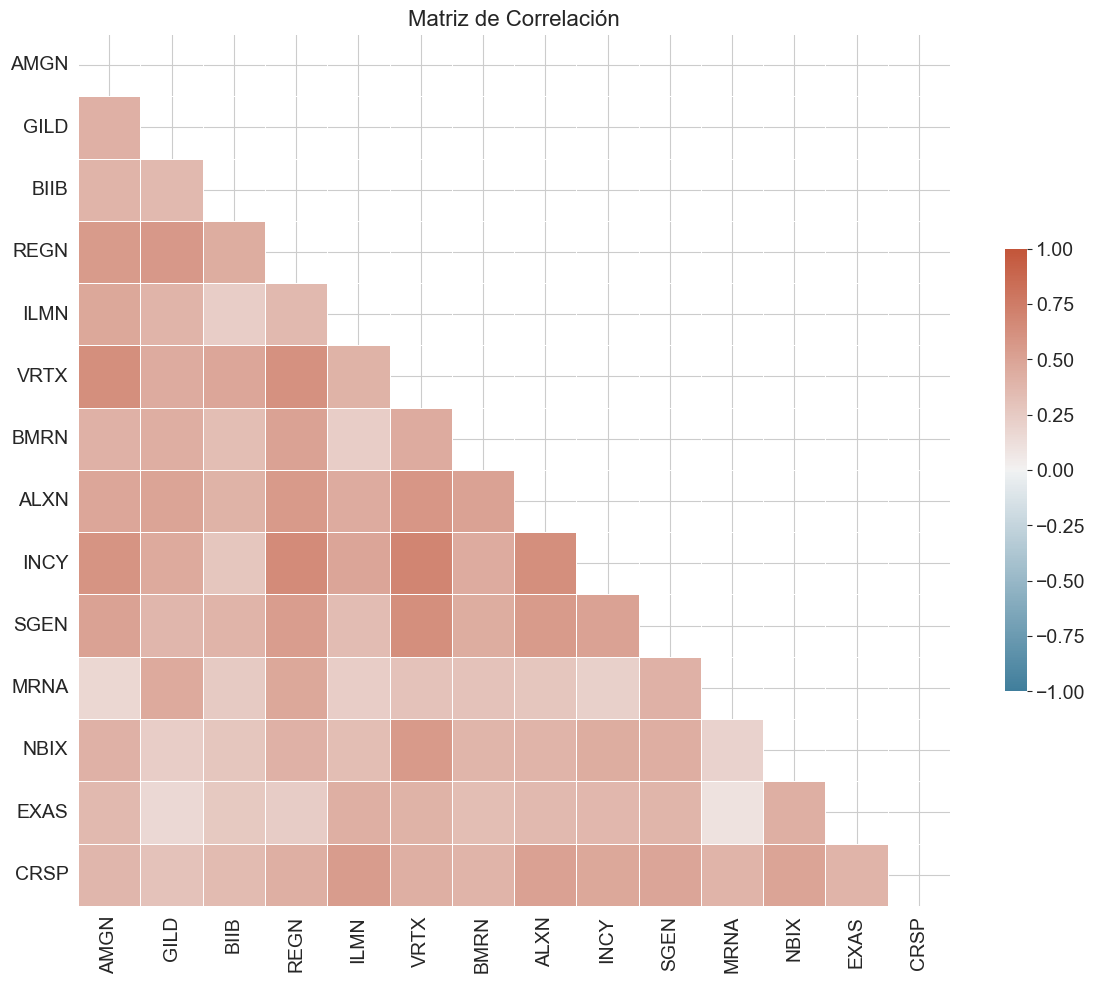


3. Simulando resultados de modelos...

4. Visualizando rendimientos acumulados...


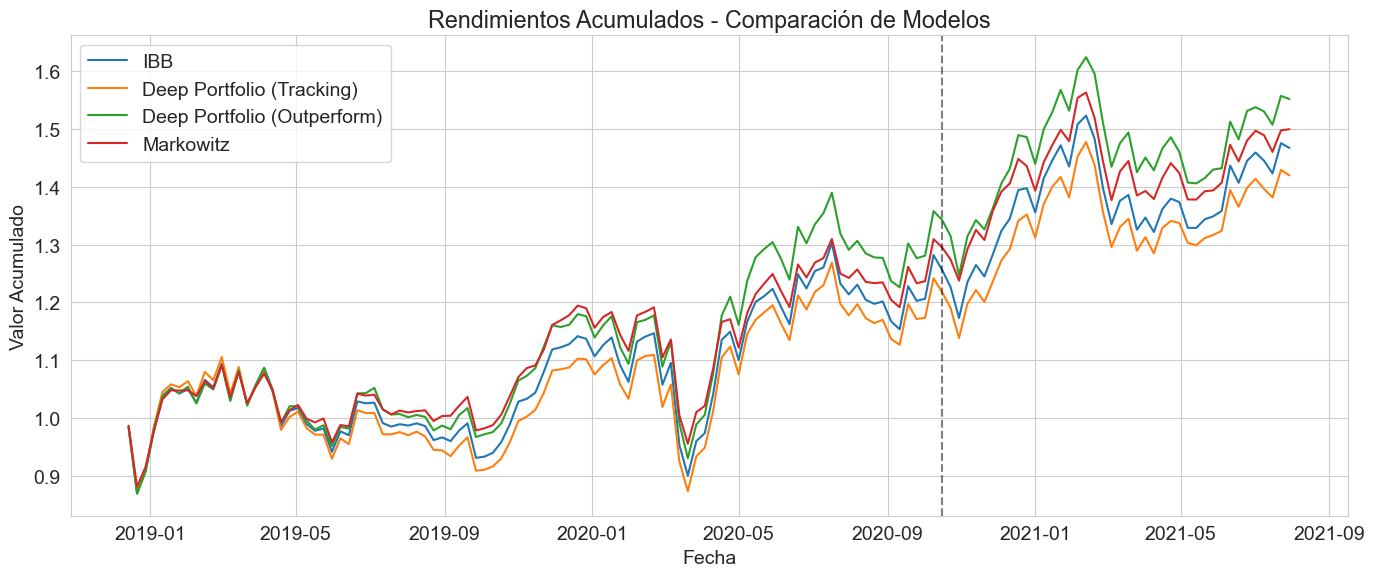


5. Simulando y evaluando un portafolio...

6. Visualizando rendimiento del portafolio...


ValueError: x and y must have same first dimension, but have shapes (41,) and (42,)

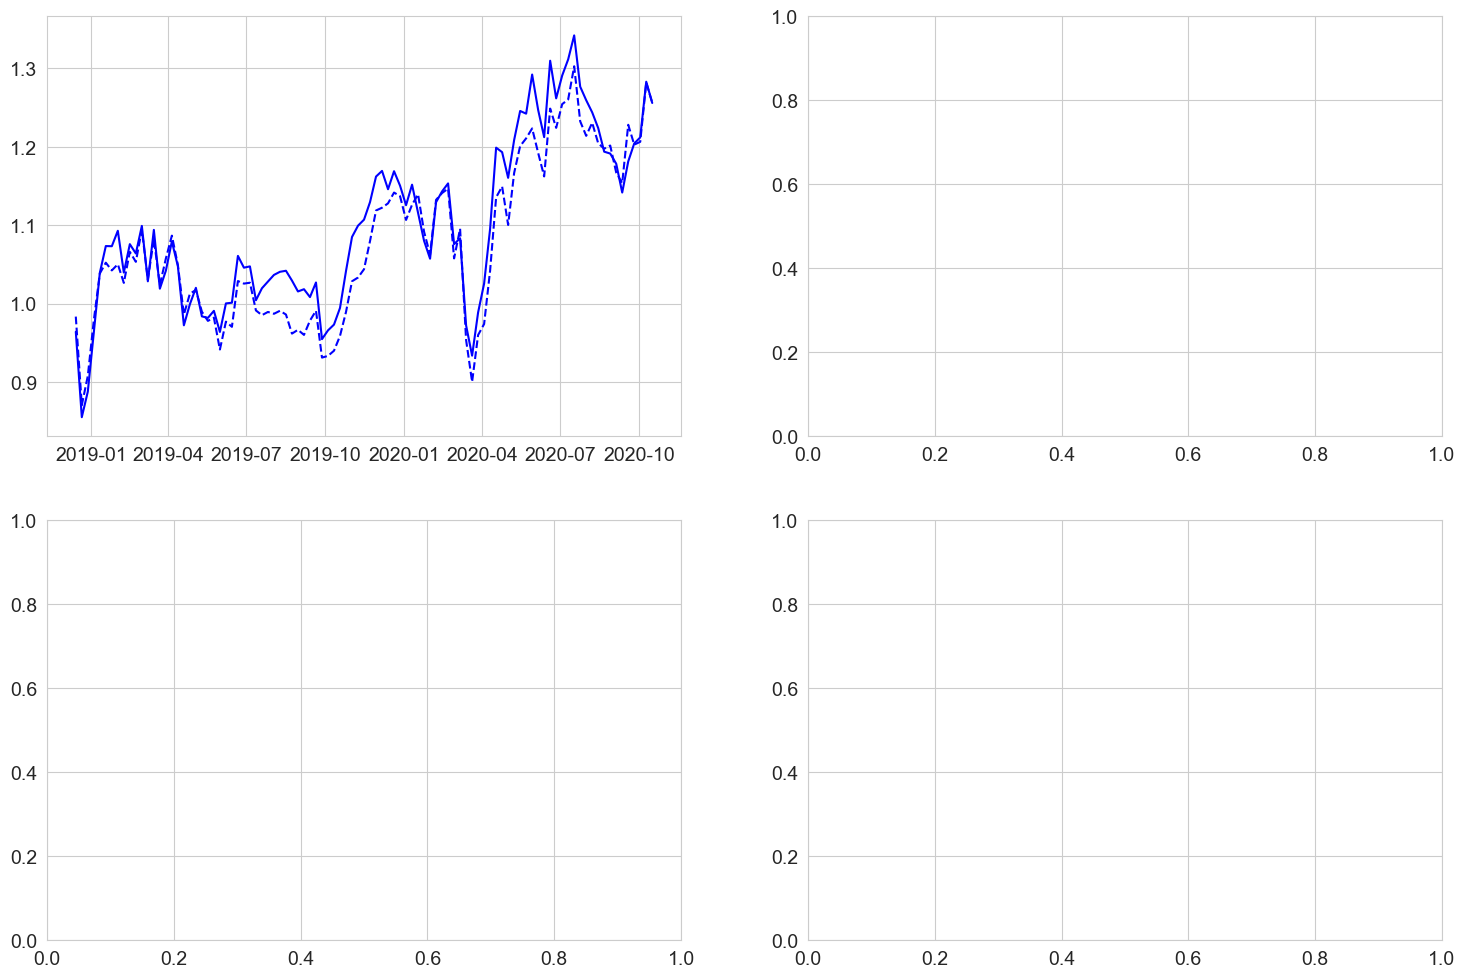

In [ ]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 14

np.random.seed(42)
tf.random.set_seed(42)


def set_plot_style(style='whitegrid', figsize=(14, 8), font_size=14):
    sns.set_style(style)
    plt.rcParams['figure.figsize'] = figsize
    plt.rcParams['font.size'] = font_size


def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directorio creado: {directory_path}")
    else:
        print(f"El directorio ya existe: {directory_path}")


def calculate_performance_metrics(y_true, y_pred, is_return_data=True, annualization_factor=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    
    metrics = {
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'mae': mae
    }
    
    if is_return_data:
        cum_true = (1 + y_true).cumprod()
        cum_pred = (1 + y_pred).cumprod()
        
        total_return_true = cum_true[-1] - 1
        total_return_pred = cum_pred[-1] - 1
        
        metrics['total_return_true'] = total_return_true
        metrics['total_return_pred'] = total_return_pred
        metrics['return_ratio'] = total_return_pred / total_return_true if total_return_true != 0 else float('inf')
        
        tracking_error = np.std(y_pred - y_true)
        metrics['tracking_error'] = tracking_error
        
        if annualization_factor is not None:
            annual_tracking_error = tracking_error * np.sqrt(annualization_factor)
            metrics['annual_tracking_error'] = annual_tracking_error
            
            vol_true = np.std(y_true) * np.sqrt(annualization_factor)
            vol_pred = np.std(y_pred) * np.sqrt(annualization_factor)
            metrics['annual_vol_true'] = vol_true
            metrics['annual_vol_pred'] = vol_pred
            
            ret_true = np.mean(y_true) * annualization_factor
            ret_pred = np.mean(y_pred) * annualization_factor
            metrics['annual_return_true'] = ret_true
            metrics['annual_return_pred'] = ret_pred
            
            sharpe_true = ret_true / vol_true if vol_true > 0 else 0
            sharpe_pred = ret_pred / vol_pred if vol_pred > 0 else 0
            metrics['sharpe_true'] = sharpe_true
            metrics['sharpe_pred'] = sharpe_pred
            
            information_ratio = (ret_pred - ret_true) / annual_tracking_error if annual_tracking_error > 0 else 0
            metrics['information_ratio'] = information_ratio
        
        max_drawdown_true = calculate_max_drawdown(cum_true)
        max_drawdown_pred = calculate_max_drawdown(cum_pred)
        metrics['max_drawdown_true'] = max_drawdown_true
        metrics['max_drawdown_pred'] = max_drawdown_pred
    
    return metrics


def calculate_max_drawdown(cum_returns):
    rolling_max = np.maximum.accumulate(cum_returns)
    drawdowns = (cum_returns / rolling_max) - 1
    max_drawdown = np.min(drawdowns)
    return max_drawdown


def plot_training_history(history, metrics=None, figsize=(12, 6)):
    if metrics is None:
        metrics = ['loss']
    
    n_metrics = len(metrics)
    fig, axs = plt.subplots(1, n_metrics, figsize=figsize)
    
    if n_metrics == 1:
        axs = [axs]
    
    for i, metric in enumerate(metrics):
        if metric in history:
            axs[i].plot(history[metric], label=f'Training {metric}')
            val_metric = f'val_{metric}'
            if val_metric in history:
                axs[i].plot(history[val_metric], label=f'Validation {metric}')
            axs[i].set_title(f'{metric.capitalize()} durante entrenamiento')
            axs[i].set_xlabel('Época')
            axs[i].set_ylabel(metric)
            axs[i].legend()
            axs[i].grid(True)
    
    plt.tight_layout()
    return fig


def plot_correlation_matrix(returns_df, title="Matriz de Correlación", figsize=(12, 10)):
    corr = returns_df.corr()
    
    fig, ax = plt.subplots(figsize=figsize)
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    
    ax.set_title(title, fontsize=16)
    
    plt.tight_layout()
    return fig


# PARTE 2: CLASES PARA MODELOS DE DEEP PORTFOLIO THEORY

class DeepPortfolioAutoencoder:
    def __init__(self, input_dim, encoding_dim=5, hidden_layers=None, reg_strength=0.01, 
                 activation='relu', learning_rate=0.001):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.hidden_layers = hidden_layers if hidden_layers is not None else [encoding_dim * 2]
        self.reg_strength = reg_strength
        self.activation = activation
        self.learning_rate = learning_rate
        
        self.autoencoder, self.encoder, self.decoder = self._build_models()
    
    def _build_models(self):
        regularizer = l1_l2(l1=self.reg_strength, l2=self.reg_strength)
        
        input_layer = Input(shape=(self.input_dim,))
        
        x = input_layer
        encoder_layers = []
        
        for i, units in enumerate(self.hidden_layers):
            x = Dense(units, activation=self.activation, kernel_regularizer=regularizer,
                      name=f'encoder_{i}')(x)
            encoder_layers.append(x)
        
        encoded = Dense(self.encoding_dim, activation=self.activation, kernel_regularizer=regularizer,
                        name='encoded')(x)
        
        x = encoded
        for i, units in enumerate(reversed(self.hidden_layers)):
            x = Dense(units, activation=self.activation, kernel_regularizer=regularizer,
                      name=f'decoder_{i}')(x)
        
        decoded = Dense(self.input_dim, activation='linear', kernel_regularizer=regularizer,
                       name='decoded')(x)
        
        autoencoder = Model(input_layer, decoded, name='autoencoder')
        encoder = Model(input_layer, encoded, name='encoder')
        
        encoded_input = Input(shape=(self.encoding_dim,))
        decoder_layers = []
        x = encoded_input
        
        for i, layer in enumerate(autoencoder.layers[len(self.hidden_layers) + 2:]):
            x = layer(x)
            decoder_layers.append(x)
        
        decoder = Model(encoded_input, x, name='decoder')
        
        autoencoder.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        
        return autoencoder, encoder, decoder
    
    def fit(self, X_train, X_valid=None, epochs=100, batch_size=32, patience=20, 
            model_path=None, verbose=1):
        callbacks = []
        
        if X_valid is not None:
            early_stopping = EarlyStopping(monitor='val_loss', patience=patience, 
                                          restore_best_weights=True)
            callbacks.append(early_stopping)
        
        if model_path is not None:
            os.makedirs(os.path.dirname(model_path), exist_ok=True)
            
            checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)
            callbacks.append(checkpoint)
        
        validation_data = (X_valid, X_valid) if X_valid is not None else None
        
        history = self.autoencoder.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=verbose
        )
        
        return history
    
    def encode(self, X):
        return self.encoder.predict(X)
    
    def decode(self, encoded_X):
        return self.decoder.predict(encoded_X)
    
    def reconstruct(self, X):
        return self.autoencoder.predict(X)
    
    def evaluate(self, X):
        return self.autoencoder.evaluate(X, X, verbose=0)


class DeepPortfolioModel:
    def __init__(self, input_dim, hidden_layers=None, reg_strength=0.01, 
                 activation='relu', learning_rate=0.001):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers if hidden_layers is not None else [32, 16]
        self.reg_strength = reg_strength
        self.activation = activation
        self.learning_rate = learning_rate
        
        self.model = self._build_model()
    
    def _build_model(self):
        regularizer = l1_l2(l1=self.reg_strength, l2=self.reg_strength)
        
        model = Sequential()
        
        model.add(Dense(self.hidden_layers[0], activation=self.activation, 
                        kernel_regularizer=regularizer, input_shape=(self.input_dim,)))
        
        for units in self.hidden_layers[1:]:
            model.add(Dense(units, activation=self.activation, kernel_regularizer=regularizer))
        
        model.add(Dense(1, activation='linear', kernel_regularizer=regularizer))
        
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        
        return model
    
    def fit(self, X_train, y_train, X_valid=None, y_valid=None, epochs=100, batch_size=32, 
            patience=20, model_path=None, verbose=1):
        callbacks = []
        
        if X_valid is not None and y_valid is not None:
            early_stopping = EarlyStopping(monitor='val_loss', patience=patience, 
                                          restore_best_weights=True)
            callbacks.append(early_stopping)
        
        if model_path is not None:
            os.makedirs(os.path.dirname(model_path), exist_ok=True)
            
            checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)
            callbacks.append(checkpoint)
        
        validation_data = (X_valid, y_valid) if X_valid is not None and y_valid is not None else None
        
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=verbose
        )
        
        return history
    
    def predict(self, X):
        return self.model.predict(X).flatten()
    
    def evaluate(self, X, y):
        return self.model.evaluate(X, y, verbose=0)

# PARTE 3: FUNCIONES PARA CONSTRUCCIÓN Y EVALUACIÓN DE PORTAFOLIOS


def create_portfolio_weights(model, X, n_assets=None, asset_names=None, method='all_assets'):
    if method not in ['all_assets', 'top_n', 'lasso']:
        raise ValueError(f"method debe ser 'all_assets', 'top_n' o 'lasso'. Valor proporcionado: {method}")
    
    if method == 'all_assets':
        if isinstance(model, tf.keras.Model):
            input_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
            with tf.GradientTape() as tape:
                tape.watch(input_tensor)
                predictions = model(input_tensor)
            gradients = tape.gradient(predictions, input_tensor)
            importance = np.abs(gradients.numpy()).mean(axis=0)
        else:
            lasso = LassoCV(cv=5).fit(X, model.predict(X))
            importance = np.abs(lasso.coef_)
        
        weights = importance / importance.sum() if importance.sum() > 0 else np.ones_like(importance) / len(importance)
        
        selected_indices = np.arange(len(weights))
        
    elif method == 'top_n':
        if n_assets is None or n_assets <= 0 or n_assets > X.shape[1]:
            raise ValueError(f"Para method='top_n', n_assets debe ser un entero positivo <= {X.shape[1]}")
        
        lasso = LassoCV(cv=5).fit(X, model.predict(X))
        importance = np.abs(lasso.coef_)
        
        selected_indices = np.argsort(importance)[::-1][:n_assets]
        
        selected_importance = importance[selected_indices]
        weights = selected_importance / selected_importance.sum() if selected_importance.sum() > 0 else np.ones(n_assets) / n_assets
        
    elif method == 'lasso':
        lasso = LassoCV(cv=5, positive=True).fit(X, model.predict(X))
        weights = lasso.coef_
        
        selected_indices = np.where(weights > 0)[0]
        weights = weights[selected_indices]
        
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
    
    if asset_names is not None:
        selected_assets = [asset_names[i] for i in selected_indices]
        weights_df = pd.DataFrame({
            'Asset': selected_assets,
            'Weight': weights
        })
    else:
        weights_df = pd.DataFrame({
            'Asset_Index': selected_indices,
            'Weight': weights
        })
    
    return {
        'weights': weights,
        'selected_indices': selected_indices,
        'weights_df': weights_df,
        'method': method
    }


def evaluate_portfolio(weights_dict, X_train, y_train, X_valid, y_valid, asset_names=None, 
                      risk_free_rate=0.0, annualization_factor=52):
    weights = weights_dict['weights']
    selected_indices = weights_dict['selected_indices']
    
    X_train_selected = X_train[:, selected_indices]
    X_valid_selected = X_valid[:, selected_indices]
    
    portfolio_returns_train = np.dot(X_train_selected, weights)
    portfolio_returns_valid = np.dot(X_valid_selected, weights)
    
    portfolio_cum_returns_train = (1 + portfolio_returns_train).cumprod()
    benchmark_cum_returns_train = (1 + y_train).cumprod()
    
    portfolio_cum_returns_valid = (1 + portfolio_returns_valid).cumprod()
    benchmark_cum_returns_valid = (1 + y_valid).cumprod()
    
    portfolio_mean_return_train = np.mean(portfolio_returns_train) * annualization_factor
    portfolio_std_train = np.std(portfolio_returns_train) * np.sqrt(annualization_factor)
    portfolio_sharpe_train = (portfolio_mean_return_train - risk_free_rate) / portfolio_std_train if portfolio_std_train > 0 else 0
    
    benchmark_mean_return_train = np.mean(y_train) * annualization_factor
    benchmark_std_train = np.std(y_train) * np.sqrt(annualization_factor)
    benchmark_sharpe_train = (benchmark_mean_return_train - risk_free_rate) / benchmark_std_train if benchmark_std_train > 0 else 0
    
    tracking_error_train = np.std(portfolio_returns_train - y_train) * np.sqrt(annualization_factor)
    information_ratio_train = (portfolio_mean_return_train - benchmark_mean_return_train) / tracking_error_train if tracking_error_train > 0 else 0
    
    portfolio_mean_return_valid = np.mean(portfolio_returns_valid) * annualization_factor
    portfolio_std_valid = np.std(portfolio_returns_valid) * np.sqrt(annualization_factor)
    portfolio_sharpe_valid = (portfolio_mean_return_valid - risk_free_rate) / portfolio_std_valid if portfolio_std_valid > 0 else 0
    
    benchmark_mean_return_valid = np.mean(y_valid) * annualization_factor
    benchmark_std_valid = np.std(y_valid) * np.sqrt(annualization_factor)
    benchmark_sharpe_valid = (benchmark_mean_return_valid - risk_free_rate) / benchmark_std_valid if benchmark_std_valid > 0 else 0
    
    tracking_error_valid = np.std(portfolio_returns_valid - y_valid) * np.sqrt(annualization_factor)
    information_ratio_valid = (portfolio_mean_return_valid - benchmark_mean_return_valid) / tracking_error_valid if tracking_error_valid > 0 else 0
    
    def calculate_drawdown(returns):
        cum_returns = (1 + returns).cumprod()
        running_max = np.maximum.accumulate(cum_returns)
        drawdown = (cum_returns / running_max) - 1
        return drawdown
    
    portfolio_drawdown_train = calculate_drawdown(portfolio_returns_train)
    benchmark_drawdown_train = calculate_drawdown(y_train)
    
    portfolio_drawdown_valid = calculate_drawdown(portfolio_returns_valid)
    benchmark_drawdown_valid = calculate_drawdown(y_valid)
    
    max_drawdown_portfolio_train = np.min(portfolio_drawdown_train)
    max_drawdown_benchmark_train = np.min(benchmark_drawdown_train)
    
    max_drawdown_portfolio_valid = np.min(portfolio_drawdown_valid)
    max_drawdown_benchmark_valid = np.min(benchmark_drawdown_valid)
    
    total_return_portfolio_train = portfolio_cum_returns_train[-1] - 1
    total_return_benchmark_train = benchmark_cum_returns_train[-1] - 1
    
    total_return_portfolio_valid = portfolio_cum_returns_valid[-1] - 1
    total_return_benchmark_valid = benchmark_cum_returns_valid[-1] - 1
    
    results = {
        'train': {
            'returns': portfolio_returns_train,
            'cum_returns': portfolio_cum_returns_train,
            'mean_return': portfolio_mean_return_train,
            'std': portfolio_std_train,
            'sharpe_ratio': portfolio_sharpe_train,
            'tracking_error': tracking_error_train,
            'information_ratio': information_ratio_train,
            'max_drawdown': max_drawdown_portfolio_train,
            'total_return': total_return_portfolio_train,
            'benchmark_returns': y_train,
            'benchmark_cum_returns': benchmark_cum_returns_train,
            'benchmark_mean_return': benchmark_mean_return_train,
            'benchmark_std': benchmark_std_train,
            'benchmark_sharpe_ratio': benchmark_sharpe_train,
            'benchmark_max_drawdown': max_drawdown_benchmark_train,
            'benchmark_total_return': total_return_benchmark_train
        },
        'valid': {
            'returns': portfolio_returns_valid,
            'cum_returns': portfolio_cum_returns_valid,
            'mean_return': portfolio_mean_return_valid,
            'std': portfolio_std_valid,
            'sharpe_ratio': portfolio_sharpe_valid,
            'tracking_error': tracking_error_valid,
            'information_ratio': information_ratio_valid,
            'max_drawdown': max_drawdown_portfolio_valid,
            'total_return': total_return_portfolio_valid,
            'benchmark_returns': y_valid,
            'benchmark_cum_returns': benchmark_cum_returns_valid,
            'benchmark_mean_return': benchmark_mean_return_valid,
            'benchmark_std': benchmark_std_valid,
            'benchmark_sharpe_ratio': benchmark_sharpe_valid,
            'benchmark_max_drawdown': max_drawdown_benchmark_valid,
            'benchmark_total_return': total_return_benchmark_valid
        },
        'portfolio': {
            'weights': weights,
            'selected_indices': selected_indices,
            'weights_df': weights_dict['weights_df'],
            'method': weights_dict['method']
        }
    }
    
    return results


def markowitz_optimization(returns, target_return=None, risk_aversion=1.0):
    n = returns.shape[1]
    returns_mean = returns.mean().values
    returns_cov = returns.cov().values
    
    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(returns_cov, weights)))
    
    def portfolio_return(weights):
        return np.sum(returns_mean * weights)
    
    def objective(weights):
        if target_return is None:
            return portfolio_volatility(weights) - risk_aversion * portfolio_return(weights)
        else:
            return portfolio_volatility(weights)
    
    constraints = []
    if target_return is not None:
        constraints.append({'type': 'eq', 'fun': lambda w: portfolio_return(w) - target_return})
    
    constraints.append({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0})
    
    bounds = tuple((0, 1) for _ in range(n))
    
    initial_weights = np.ones(n) / n
    
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result['x']


def plot_portfolio_performance(evaluation_results, train_dates, valid_dates, title=None):
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    
    portfolio_cum_returns_train = evaluation_results['train']['cum_returns']
    benchmark_cum_returns_train = evaluation_results['train']['benchmark_cum_returns']
    
    portfolio_cum_returns_valid = evaluation_results['valid']['cum_returns']
    benchmark_cum_returns_valid = evaluation_results['valid']['benchmark_cum_returns']
    
    axs[0, 0].plot(train_dates, portfolio_cum_returns_train, label='Portfolio (Train)', color='blue')
    axs[0, 0].plot(train_dates, benchmark_cum_returns_train, label='Benchmark (Train)', color='blue', linestyle='--')
    axs[0, 0].plot(valid_dates, portfolio_cum_returns_valid, label='Portfolio (Valid)', color='green')
    axs[0, 0].plot(valid_dates, benchmark_cum_returns_valid, label='Benchmark (Valid)', color='green', linestyle='--')
    
    axs[0, 0].axvline(x=train_dates[-1], color='red', linestyle='-', alpha=0.3)
    axs[0, 0].text(train_dates[-1], 0.5, 'Train | Valid', rotation=90, transform=axs[0, 0].get_xaxis_transform())
    
    axs[0, 0].set_title('Rendimientos Acumulados')
    axs[0, 0].set_xlabel('Fecha')
    axs[0, 0].set_ylabel('Valor')
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    
    portfolio_drawdown_train = (evaluation_results['train']['cum_returns'] / np.maximum.accumulate(evaluation_results['train']['cum_returns'])) - 1
    benchmark_drawdown_train = (evaluation_results['train']['benchmark_cum_returns'] / np.maximum.accumulate(evaluation_results['train']['benchmark_cum_returns'])) - 1
    
    portfolio_drawdown_valid = (evaluation_results['valid']['cum_returns'] / np.maximum.accumulate(evaluation_results['valid']['cum_returns'])) - 1
    benchmark_drawdown_valid = (evaluation_results['valid']['benchmark_cum_returns'] / np.maximum.accumulate(evaluation_results['valid']['benchmark_cum_returns'])) - 1
    
    axs[0, 1].plot(train_dates, portfolio_drawdown_train, label='Portfolio (Train)', color='blue')
    axs[0, 1].plot(train_dates, benchmark_drawdown_train, label='Benchmark (Train)', color='blue', linestyle='--')
    axs[0, 1].plot(valid_dates, portfolio_drawdown_valid, label='Portfolio (Valid)', color='green')
    axs[0, 1].plot(valid_dates, benchmark_drawdown_valid, label='Benchmark (Valid)', color='green', linestyle='--')
    
    axs[0, 1].axvline(x=train_dates[-1], color='red', linestyle='-', alpha=0.3)
    
    axs[0, 1].set_title('Drawdowns')
    axs[0, 1].set_xlabel('Fecha')
    axs[0, 1].set_ylabel('Drawdown')
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    
    weights_df = evaluation_results['portfolio']['weights_df']
    
    weights_df = weights_df.sort_values('Weight', ascending=False)
    
    top_n = min(10, len(weights_df))
    top_weights = weights_df.head(top_n)
    
    axs[1, 0].bar(top_weights['Asset'], top_weights['Weight'])
    axs[1, 0].set_title(f'Top {top_n} Pesos del Portafolio')
    axs[1, 0].set_xlabel('Activo')
    axs[1, 0].set_ylabel('Peso')
    axs[1, 0].tick_params(axis='x', rotation=45)
    axs[1, 0].grid(True, axis='y')
    
    metrics = [
        ('Rendimiento Medio (Train)', f"{evaluation_results['train']['mean_return']:.2%}", f"{evaluation_results['train']['benchmark_mean_return']:.2%}"),
        ('Volatilidad (Train)', f"{evaluation_results['train']['std']:.2%}", f"{evaluation_results['train']['benchmark_std']:.2%}"),
        ('Sharpe Ratio (Train)', f"{evaluation_results['train']['sharpe_ratio']:.2f}", f"{evaluation_results['train']['benchmark_sharpe_ratio']:.2f}"),
        ('Tracking Error (Train)', f"{evaluation_results['train']['tracking_error']:.2%}", "N/A"),
        ('Information Ratio (Train)', f"{evaluation_results['train']['information_ratio']:.2f}", "N/A"),
        ('Max Drawdown (Train)', f"{evaluation_results['train']['max_drawdown']:.2%}", f"{evaluation_results['train']['benchmark_max_drawdown']:.2%}"),
        ('Retorno Total (Train)', f"{evaluation_results['train']['total_return']:.2%}", f"{evaluation_results['train']['benchmark_total_return']:.2%}"),
        ('Rendimiento Medio (Valid)', f"{evaluation_results['valid']['mean_return']:.2%}", f"{evaluation_results['valid']['benchmark_mean_return']:.2%}"),
        ('Volatilidad (Valid)', f"{evaluation_results['valid']['std']:.2%}", f"{evaluation_results['valid']['benchmark_std']:.2%}"),
        ('Sharpe Ratio (Valid)', f"{evaluation_results['valid']['sharpe_ratio']:.2f}", f"{evaluation_results['valid']['benchmark_sharpe_ratio']:.2f}"),
        ('Tracking Error (Valid)', f"{evaluation_results['valid']['tracking_error']:.2%}", "N/A"),
        ('Information Ratio (Valid)', f"{evaluation_results['valid']['information_ratio']:.2f}", "N/A"),
        ('Max Drawdown (Valid)', f"{evaluation_results['valid']['max_drawdown']:.2%}", f"{evaluation_results['valid']['benchmark_max_drawdown']:.2%}"),
        ('Retorno Total (Valid)', f"{evaluation_results['valid']['total_return']:.2%}", f"{evaluation_results['valid']['benchmark_total_return']:.2%}")
    ]
    
    axs[1, 1].axis('tight')
    axs[1, 1].axis('off')
    
    table = axs[1, 1].table(
        cellText=[[m[0], m[1], m[2]] for m in metrics],
        colLabels=['Métrica', 'Portafolio', 'Benchmark'],
        loc='center',
        colWidths=[0.4, 0.3, 0.3]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    if title:
        plt.subplots_adjust(top=0.93)
    
    return fig



# PARTE 4: VISUALIZACIONES INTERACTIVAS CON PLOTLY


def plot_cumulative_returns_plotly(dates, returns_dict, title="Rendimientos Acumulados", 
                                  train_valid_split=None):
    fig = go.Figure()
    
    for name, returns in returns_dict.items():
        cum_returns = (1 + returns).cumprod()
        
        fig.add_trace(go.Scatter(
            x=dates,
            y=cum_returns,
            mode='lines',
            name=name
        ))
    
    if train_valid_split is not None:
        fig.add_vline(x=train_valid_split, line_width=1, line_dash="dash", line_color="black")
        fig.add_annotation(x=train_valid_split, y=0.5,
                    text="Train | Valid",
                    showarrow=False,
                    textangle=-90)
    
    fig.update_layout(
        title=title,
        xaxis_title='Fecha',
        yaxis_title='Valor Acumulado',
        legend_title='Series',
        template='plotly_white',
        height=600
    )
    
    return fig


def plot_efficient_frontier_plotly(n_assets, metrics_dict, title="Frontera Eficiente Profunda"):
    metrics = list(next(iter(metrics_dict.values())).keys())
    n_metrics = len(metrics)
    
    fig = make_subplots(rows=1, cols=n_metrics, 
                       subplot_titles=[m.replace('_', ' ').title() for m in metrics])
    
    for i, metric in enumerate(metrics):
        col = i + 1
        
        for name, metric_values in metrics_dict.items():
            fig.add_trace(
                go.Scatter(
                    x=n_assets,
                    y=metric_values[metric],
                    mode='lines+markers',
                    name=f"{name} - {metric}",
                    showlegend=(col == 1)
                ),
                row=1, col=col
            )
    
    fig.update_layout(
        title=title,
        height=500,
        template='plotly_white'
    )
    
    for i in range(n_metrics):
        fig.update_xaxes(title_text='Número de Activos', row=1, col=i+1)
    
    return fig


def plot_portfolio_weights_plotly(weights_dict, title="Pesos de Portafolio"):
    all_assets = set()
    for df in weights_dict.values():
        all_assets.update(df['Asset'])
    
    all_assets = sorted(list(all_assets))
    
    fig = go.Figure()
    
    for name, df in weights_dict.items():
        weights = dict(zip(df['Asset'], df['Weight']))
        
        asset_weights = [weights.get(asset, 0) for asset in all_assets]
        
        fig.add_trace(go.Bar(
            x=all_assets,
            y=asset_weights,
            name=name
        ))
    
    fig.update_layout(
        title=title,
        xaxis_title='Activo',
        yaxis_title='Peso',
        legend_title='Portafolio',
        barmode='group',
        template='plotly_white',
        height=600
    )
    
    return fig


# PARTE 5: EJECUCIÓN PRINCIPAL


def main():
    print("Deep Portfolio Theory - Visualización y Análisis")
    print("===============================================")
    
    # Cargar datos
    print("\n1. Cargando datos...")
    try:
        train_data = pd.read_csv("../data/train_weekly_returns.csv", index_col=0, parse_dates=True)
        valid_data = pd.read_csv("../data/valid_weekly_returns.csv", index_col=0, parse_dates=True)
        all_returns = pd.read_csv("../data/all_weekly_returns.csv", index_col=0, parse_dates=True)
        
        ibb_train = train_data['IBB']
        assets_train = train_data.drop('IBB', axis=1)
        
        ibb_valid = valid_data['IBB']
        assets_valid = valid_data.drop('IBB', axis=1)
        
        asset_names = assets_train.columns.tolist()
        
        print(f"Datos cargados. Periodo: {all_returns.index.min()} a {all_returns.index.max()}")
        print(f"Activos: {len(asset_names)}")
    except Exception as e:
        print(f"Error al cargar datos: {str(e)}")
        print("Generando datos simulados para demostración...")
        
        np.random.seed(42)
        n_assets = 15
        n_periods = 200
        
        dates = pd.date_range('2020-01-01', periods=n_periods, freq='W-FRI')
        
        asset_returns = np.random.normal(0.001, 0.02, (n_periods, n_assets))
        asset_names = [f"Asset_{i}" for i in range(n_assets)]
        
        benchmark_weights = np.random.random(n_assets)
        benchmark_weights = benchmark_weights / benchmark_weights.sum()
        benchmark_returns = np.dot(asset_returns, benchmark_weights) + np.random.normal(0, 0.005, n_periods)
        
        assets_df = pd.DataFrame(asset_returns, index=dates, columns=asset_names)
        benchmark_df = pd.Series(benchmark_returns, index=dates, name='IBB')
        
        all_returns = pd.concat([assets_df, benchmark_df], axis=1)
        
        cutoff = int(n_periods * 0.7)
        train_dates = dates[:cutoff]
        valid_dates = dates[cutoff:]
        
        train_data = all_returns.loc[train_dates]
        valid_data = all_returns.loc[valid_dates]
        
        ibb_train = train_data['IBB']
        assets_train = train_data.drop('IBB', axis=1)
        
        ibb_valid = valid_data['IBB']
        assets_valid = valid_data.drop('IBB', axis=1)
        
        print(f"Datos simulados creados. Periodo: {all_returns.index.min()} a {all_returns.index.max()}")
        print(f"Activos: {len(asset_names)}")
    
    # Normalizar datos
    scaler = StandardScaler()
    assets_train_scaled = scaler.fit_transform(assets_train)
    assets_valid_scaled = scaler.transform(assets_valid)
    
    # Visualizar correlación de activos
    print("\n2. Visualizando matriz de correlación...")
    corr_fig = plot_correlation_matrix(assets_train)
    plt.tight_layout()
    plt.show()
    
    # Simulación de resultados de modelos para visualización
    print("\n3. Simulando resultados de modelos...")
    dates = all_returns.index
    ibb_returns = all_returns['IBB']
    
    np.random.seed(42)
    tracking_returns = ibb_returns + np.random.normal(0, 0.003, len(ibb_returns))
    outperform_returns = ibb_returns + 0.0002 + np.random.normal(0, 0.004, len(ibb_returns))
    markowitz_returns = ibb_returns * 0.9 + np.random.normal(0, 0.005, len(ibb_returns))
    
    # Separar en entrenamiento y validación
    cutoff = len(train_data)
    train_dates = dates[:cutoff]
    valid_dates = dates[cutoff:]
    
    # Visualizar rendimientos acumulados con Plotly
    print("\n4. Visualizando rendimientos acumulados...")
    returns_dict = {
        'IBB': ibb_returns,
        'Deep Portfolio (Tracking)': tracking_returns,
        'Deep Portfolio (Outperform)': outperform_returns,
        'Markowitz': markowitz_returns
    }
    
    # Crear y mostrar gráfico interactivo (en entornos que soporten Plotly)
    cum_returns_fig = plot_cumulative_returns_plotly(
        dates=dates,
        returns_dict=returns_dict,
        title='Rendimientos Acumulados - Comparación de Modelos',
        train_valid_split=train_dates[-1]
    )
    
    # Para entornos que no soportan Plotly, también mostramos con Matplotlib
    plt.figure(figsize=(14, 6))
    for name, returns in returns_dict.items():
        cum_returns = (1 + returns).cumprod()
        plt.plot(dates, cum_returns, label=name)
    
    plt.axvline(x=train_dates[-1], color='black', linestyle='--', alpha=0.5)
    plt.title('Rendimientos Acumulados - Comparación de Modelos')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Acumulado')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Simulación de portafolio y evaluación
    print("\n5. Simulando y evaluando un portafolio...")
    
    # Crear pesos de portafolio simulados
    np.random.seed(42)
    weights = np.random.random(len(asset_names))
    weights = weights / weights.sum()
    
    weights_dict = {
        'weights': weights,
        'selected_indices': np.arange(len(asset_names)),
        'weights_df': pd.DataFrame({
            'Asset': asset_names,
            'Weight': weights
        }),
        'method': 'simulated'
    }
    
    # Evaluar portafolio
    portfolio_eval = evaluate_portfolio(
        weights_dict=weights_dict,
        X_train=assets_train.values,
        y_train=ibb_train.values,
        X_valid=assets_valid.values,
        y_valid=ibb_valid.values,
        asset_names=asset_names,
        risk_free_rate=0.0,
        annualization_factor=52
    )
    
    # Visualizar rendimiento del portafolio
    print("\n6. Visualizando rendimiento del portafolio...")
    portfolio_fig = plot_portfolio_performance(
        evaluation_results=portfolio_eval,
        train_dates=train_dates,
        valid_dates=valid_dates,
        title='Análisis de Rendimiento de Portafolio'
    )
    plt.tight_layout()
    plt.show()
    
    # Simulación de frontera eficiente profunda
    print("\n7. Simulando y visualizando frontera eficiente profunda...")
    n_assets = [3, 5, 7, 9, 11, 13, 15]
    
    # Simulamos métricas para frontera eficiente
    tracking_errors = [0.09, 0.075, 0.068, 0.062, 0.058, 0.055, 0.053]
    sharpe_ratios = [0.45, 0.52, 0.58, 0.63, 0.66, 0.68, 0.69]
    
    tracking_errors_outperform = [0.11, 0.095, 0.085, 0.078, 0.072, 0.068, 0.065]
    sharpe_ratios_outperform = [0.48, 0.55, 0.61, 0.65, 0.68, 0.70, 0.71]
    
    # Crear diccionario para visualización
    frontier_metrics = {
        'Seguimiento': {
            'tracking_error': tracking_errors,
            'sharpe_ratio': sharpe_ratios
        },
        'Superación': {
            'tracking_error': tracking_errors_outperform,
            'sharpe_ratio': sharpe_ratios_outperform
        }
    }
    
    # Crear y mostrar frontera eficiente con Plotly
    frontier_fig = plot_efficient_frontier_plotly(
        n_assets=n_assets,
        metrics_dict=frontier_metrics,
        title='Frontera Eficiente Profunda'
    )
    
    # Para entornos que no soportan Plotly, también mostramos con Matplotlib
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(n_assets, tracking_errors, 'o-', label='Seguimiento')
    plt.plot(n_assets, tracking_errors_outperform, 's-', label='Superación')
    plt.title('Tracking Error vs Número de Activos')
    plt.xlabel('Número de Activos')
    plt.ylabel('Tracking Error')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(n_assets, sharpe_ratios, 'o-', label='Seguimiento')
    plt.plot(n_assets, sharpe_ratios_outperform, 's-', label='Superación')
    plt.title('Sharpe Ratio vs Número de Activos')
    plt.xlabel('Número de Activos')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\nDemostración completada. Para implementar en su proyecto, adapte este código a sus datos y requisitos específicos.")


# Si se ejecuta como script principal
if __name__ == "__main__":
    main()